# Solubility LRP 

In [1]:
# %matplotlib inline
%matplotlib agg
%matplotlib agg
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import sys
import torch
import numpy as np
import torch_scatter
import torchgraphs as tg

import yaml
import pandas as pd
from rdkit import Chem
from pathlib import Path
from munch import munchify
from collections import OrderedDict

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display, HTML, SVG, Markdown

import solubility.dataset
from solubility.dataset import SolubilityDataset, smiles_to_graph
from solubility.networks import SolubilityGN
from utils import import_
import relevance

def label_bin(label):
    return '$+$' if bool(label>0) else '$-$'

def label_cat(label):
        return '$+$' if bool(label>0) else '$\cdot$'

In [2]:
def mol_to_networkx(m):
    g = nx.Graph()
    for a in m.GetAtoms():
        g.add_node(a.GetIdx(), symbol=a.GetSymbol())
    for b in m.GetBonds():
        g.add_edge(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), bond=str(b.GetBondType()))
    return g

def autocrop(im, bgcolor='white'):
    if im.mode != "RGB":
        im = im.convert("RGB")
    bg = Image.new("RGB", im.size, bgcolor)
    diff = ImageChops.difference(im, bg)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
    return None # no contents

In [3]:
from PIL import Image, ImageChops
from io import BytesIO

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

def moltosvg(mol,node_colors={}, edge_colors={}, molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .1
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(node_colors))], 
        highlightAtomColors={i: tuple(c) for i, c in enumerate(node_colors)}, 
        highlightBonds=[i for i in range(len(edge_colors))],
        highlightBondColors={i: tuple(c) for i, c in enumerate(edge_colors)},
        highlightAtomRadii={i: .5 for i in range(len(node_colors))}
    )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    # svg = svg.replace('svg:','')
    return svg

In [4]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

def moltopng(mol,node_colors, edge_colors, molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(node_colors))], 
        highlightAtomColors={i: tuple(c) for i, c in enumerate(node_colors)}, 
        highlightBonds=[i for i in range(len(edge_colors))],
        highlightBondColors={i: tuple(c) for i, c in enumerate(edge_colors)},
        highlightAtomRadii={i: .5 for i in range(len(node_colors))}
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

## Load molecules

In [5]:
ds = SolubilityDataset('../data/delaney-processed.csv')
display(ds.df.sort_values('measured log solubility in mols per litre').head())
display(ds.df.sort_values('measured log solubility in mols per litre').tail())

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
603,"2,2',3,3',4,4',5,5',6,6'-PCB",-9.589,1,498.662,0,2,1,0.0,-11.600,Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)c2c(Cl)c(Cl)c(Cl)c(C...
718,Coronene,-6.885,2,300.360,0,7,0,0.0,-9.332,c1cc2ccc3ccc4ccc5ccc6ccc1c7c2c3c4c5c67
297,"2,2',3,3',4,4',5,5'-PCB",-8.468,1,429.772,0,2,1,0.0,-9.160,Clc1cc(c(Cl)c(Cl)c1Cl)c2cc(Cl)c(Cl)c(Cl)c2Cl
60,"2,2',3,3',5,5',6,6'-PCB",-8.304,1,429.772,0,2,1,0.0,-9.150,Clc1cc(Cl)c(Cl)c(c1Cl)c2c(Cl)c(Cl)cc(Cl)c2Cl
676,Benzo[ghi]perylene,-6.446,2,276.338,0,6,0,0.0,-9.018,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
679,Glycerol,0.688,1,92.094,3,0,2,60.69,1.120,OCC(O)CO
1064,vamidothion,-1.446,1,287.343,1,0,8,64.63,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
201,Methyl hydrazine,0.543,1,46.073,2,0,0,38.05,1.340,CNN
146,Methanol,0.441,1,32.042,1,0,0,20.23,1.570,CO
605,Acetamide,0.494,1,59.068,1,0,0,43.09,1.580,CC(=O)N


In [6]:
mols = [Chem.MolFromSmiles(s) for s in ds.df.sort_values('measured log solubility in mols per litre', ascending=False).head(8).smiles]
names = ds.df.sort_values('measured log solubility in mols per litre', ascending=False).head(8)['Compound ID']
svg = Draw.MolsToGridImage(mols, molsPerRow=2, useSVG=True, subImgSize=(400, 200), legends=list(names))
display(HTML(svg))

In [7]:
mols = [Chem.MolFromSmiles(s) for s in ds.df.sort_values('measured log solubility in mols per litre', ascending=True).head(8).smiles]
names = ds.df.sort_values('measured log solubility in mols per litre', ascending=True).head(8)['Compound ID']
svg = Draw.MolsToGridImage(mols, molsPerRow=2, useSVG=True, subImgSize=(400, 200), legends=list(names))
display(HTML(svg))

## Import trained model

In [8]:
experiment = Path('../models/solubility/layers3_lr.01_biasyes_size64_wd.001_dryes_e50_sum_KCJGWG/') # best, val loss 0.5948061519316165

with experiment.joinpath('experiment.latest.yaml').open('r') as f:
    model = munchify(yaml.safe_load(f)['model'])
model.state_dict = experiment / 'model.latest.pt'

if 'aggregation' not in model.kwargs:
    model.kwargs['aggregation'] = 'mean'

net = SolubilityGN(*model.args, **model.kwargs)
net.load_state_dict(torch.load(model.state_dict, map_location='cpu'))
net.eval();

In [9]:
class SolubilityRelevance(SolubilityGN):
    def __init__(self, num_layers, hidden_bias, hidden_node, dropout, aggregation):
        super(SolubilityGN, self).__init__()

        hidden_edge = hidden_node // 4
        hidden_global = hidden_node // 8
        
        self.encoder = torch.nn.Sequential(OrderedDict({
            'edge': relevance.EdgeLinearRelevance(hidden_edge, edge_features=6),
            'edge_relu': relevance.EdgeReLURelevance(),
            'node': relevance.NodeLinearRelevance(hidden_node, node_features=47),
            'node_relu': relevance.NodeReLURelevance(),
            'global': relevance.GlobalLinearRelevance(hidden_global, node_features=hidden_node,
                                      edge_features=hidden_edge, aggregation=aggregation),
            'global_relu': relevance.GlobalReLURelevance(),
        }))
        if dropout:
            self.hidden = torch.nn.Sequential(OrderedDict({
                f'hidden_{i}': torch.nn.Sequential(OrderedDict({
                    'edge': relevance.EdgeLinearRelevance(hidden_edge, edge_features=hidden_edge,
                                          sender_features=hidden_node, bias=hidden_bias),
                    'edge_relu': relevance.EdgeReLURelevance(),
                    'edge_dropout': tg.EdgeDroput(),
                    'node': relevance.NodeLinearRelevance(hidden_node, node_features=hidden_node, incoming_features=hidden_edge,
                                          aggregation=aggregation, bias=hidden_bias),
                    'node_relu': relevance.NodeReLURelevance(),
                    'node_dropout': tg.EdgeDroput(),
                    'global': relevance.GlobalLinearRelevance(hidden_global, node_features=hidden_node, edge_features=hidden_edge,
                                              global_features=hidden_global, aggregation=aggregation, bias=hidden_bias),
                    'global_relu': relevance.GlobalReLURelevance(),
                    'global_dropout': tg.EdgeDroput(),
                }))
                for i in range(num_layers)
            }))
        else:
            self.hidden = torch.nn.Sequential(OrderedDict({
                f'hidden_{i}': torch.nn.Sequential(OrderedDict({
                    'edge': relevance.EdgeLinearRelevance(hidden_edge, edge_features=hidden_edge,
                                          sender_features=hidden_node, bias=hidden_bias),
                    'edge_relu': relevance.EdgeReLURelevance(),
                    'node': relevance.NodeLinearRelevance(hidden_node, node_features=hidden_node, incoming_features=hidden_edge,
                                          aggregation=aggregation, bias=hidden_bias),
                    'node_relu': relevance.NodeReLURelevance(),
                    'global': relevance.GlobalLinearRelevance(hidden_global, node_features=hidden_node, edge_features=hidden_edge,
                                              global_features=hidden_global, aggregation=aggregation, bias=hidden_bias),
                    'global_relu': relevance.GlobalReLURelevance(),
                }))
                for i in range(num_layers)
            }))
        self.readout_globals = relevance.GlobalLinearRelevance(1, global_features=hidden_global, bias=True)

net_rel = SolubilityRelevance(*model.args, **model.kwargs)
net_rel.load_state_dict(torch.load(model.state_dict, map_location='cpu'))
net_rel.eval();

## Predict all

In [10]:
batch, _ = tg.GraphBatch.collate(list(ds))

solubility_out = net(batch).global_features.squeeze()

solubility_out = pd.Series(solubility_out.detach().numpy(), name='MyPrediction', index=ds.df.index)

df_out = pd.merge(solubility_out, ds.df, left_index=True, right_index=True, sort=False)
df_out['mse_loss'] = (df_out['measured log solubility in mols per litre'] - df_out.MyPrediction) ** 2

display(df_out.sort_values('mse_loss').head())
display(df_out.sort_values('mse_loss').tail())

print(df_out.mse_loss.mean())

,MyPrediction,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mse_loss
705,-1.520458,"2,2-Dimethylpentanol",-1.719,1,116.204,1,0,3,20.23,-1.520,CCCC(C)(C)CO,2.093119e-07
468,-2.798960,Carbofuran,-3.050,1,221.256,1,2,1,47.56,-2.800,CNC(=O)Oc1cccc2CC(C)(C)Oc12,1.080670e-06
961,-5.282854,methyltestosterone acetate,-4.863,1,344.495,0,4,1,43.37,-5.284,CC(=O)OC3(C)CCC4C2CCC1=CC(=O)CCC1(C)C2CCC34C,1.314225e-06
1019,-7.201161,"P,P'-DDD",-6.008,1,320.046,0,2,3,0.00,-7.200,ClC(Cl)C(c1ccc(Cl)cc1)c2ccc(Cl)cc2,1.347707e-06
450,-7.201161,DDD,-6.008,1,320.046,0,2,3,0.00,-7.200,ClC(Cl)C(c1ccc(Cl)cc1)c2ccc(Cl)cc2,1.347707e-06


,MyPrediction,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mse_loss
918,-1.052397,guanine,-0.670,1,151.129,3,2,0,100.45,-3.583,Nc2nc1[nH]cnc1c(=O)[nH]2,6.403953
292,-2.035425,Dimecron,-2.426,1,299.691,0,0,8,65.07,0.523,CCN(CC)C(=O)C(=CCOP(=O)(OC)OC)Cl,6.545537
939,-7.105923,bromadiolone,-7.877,1,527.414,2,5,6,70.67,-4.445,OC(CC(c1ccccc1)c3c(O)c2ccccc2oc3=O)c4ccc(cc4)c...,7.080512
1064,-2.374049,vamidothion,-1.446,1,287.343,1,0,8,64.63,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC),12.376668
299,-12.747044,hexacosane,-9.702,1,366.718,0,0,23,0.00,-8.334,CCCCCCCCCCCCCCCCCCCCCCCCCC,19.474954


0.49367247192935815


## LRP

### CCCCCCCCCCCCCCCCCC(=O)O

nan	-6.1

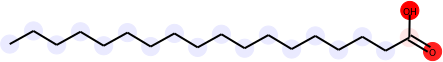

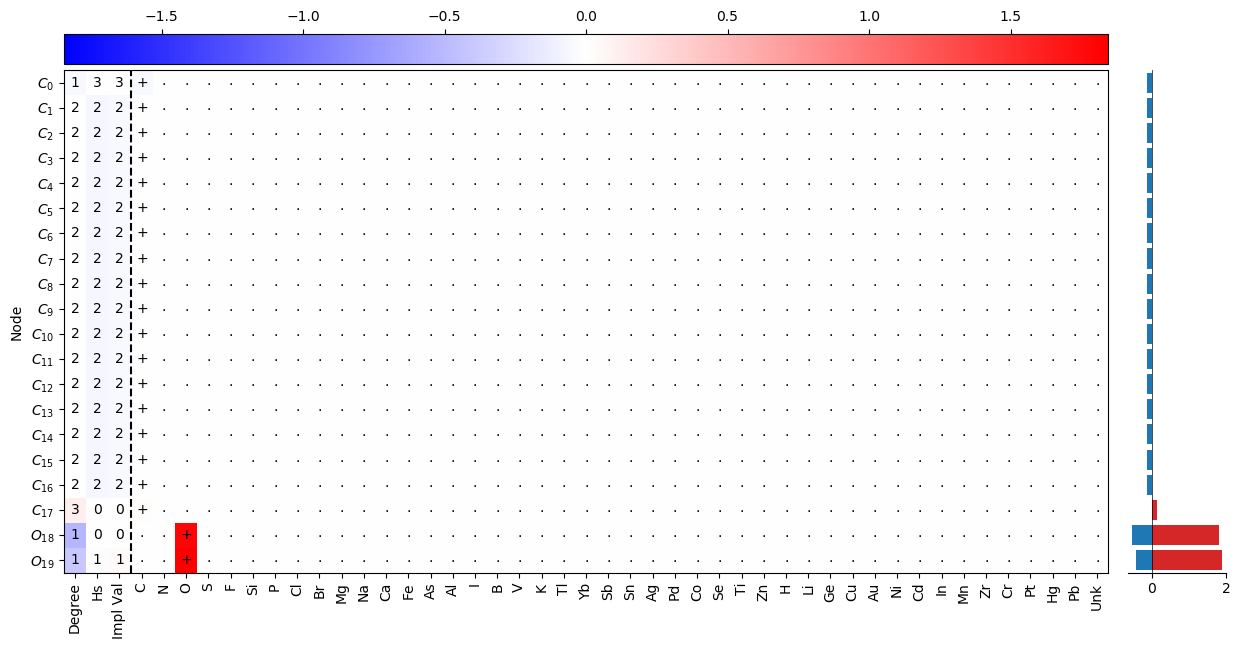

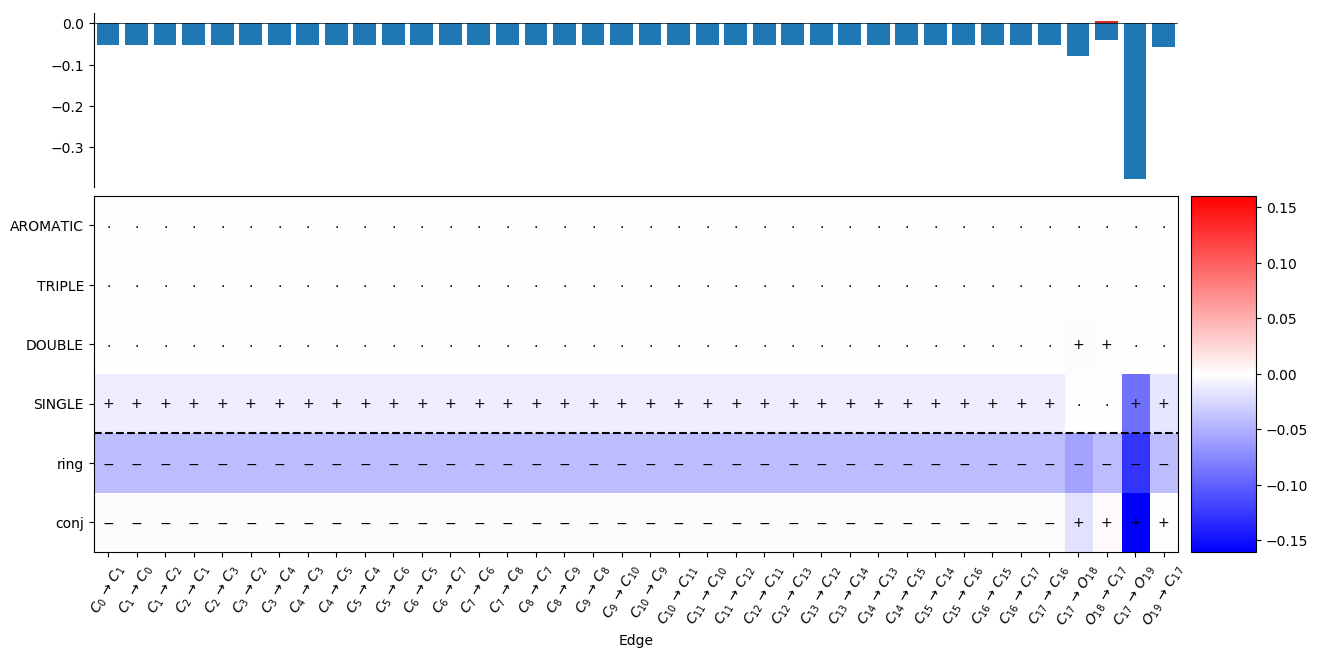

---

### C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O

nan	0.32

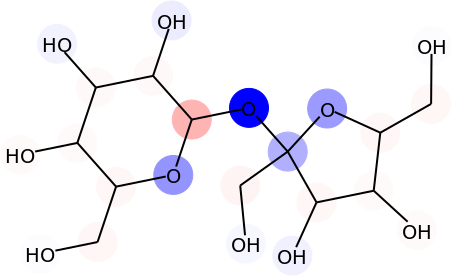

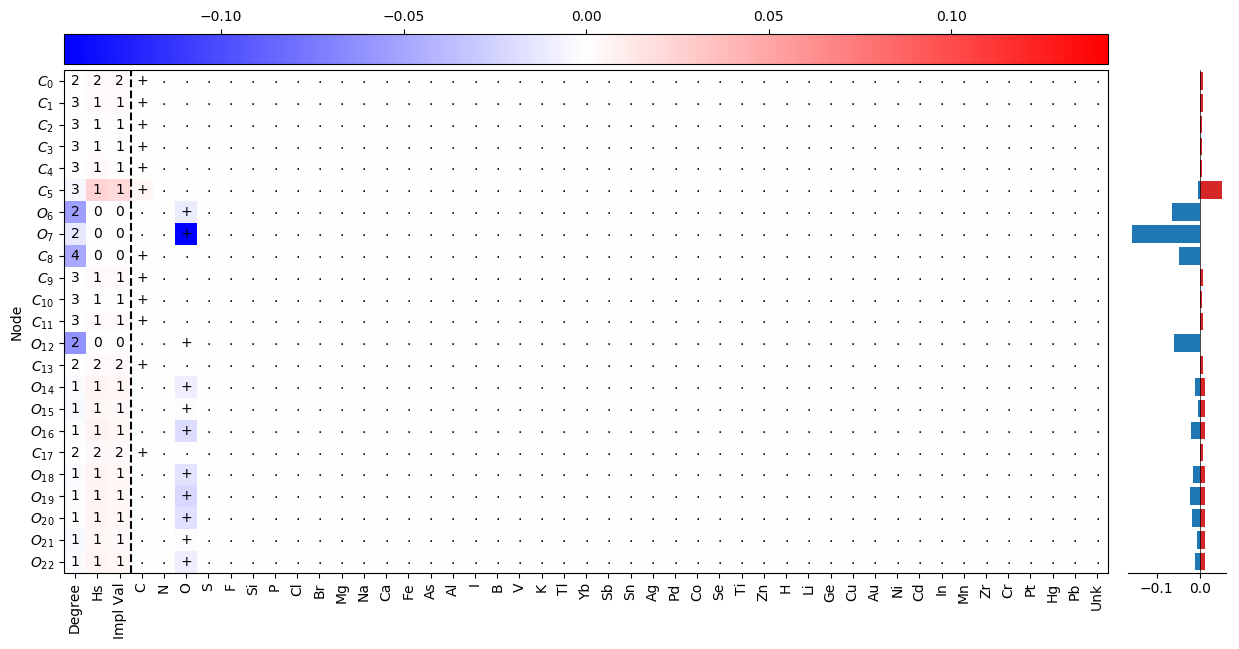

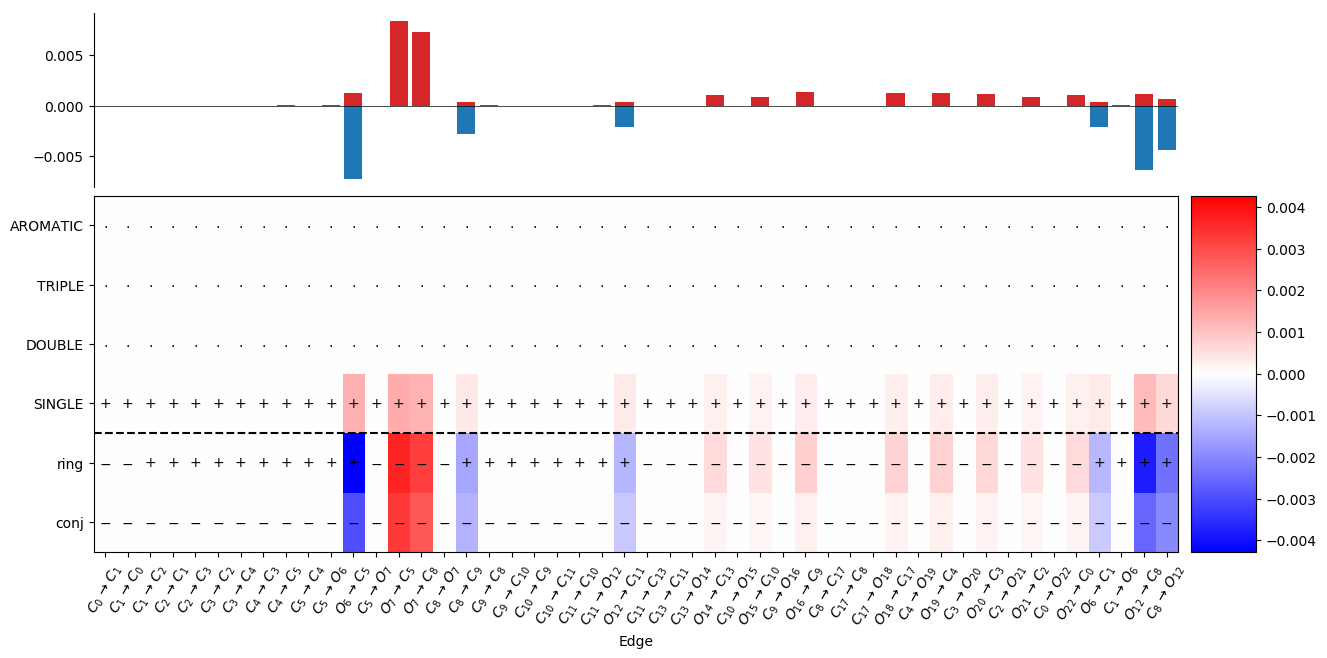

---

### c1ccccc1

nan	-1.45

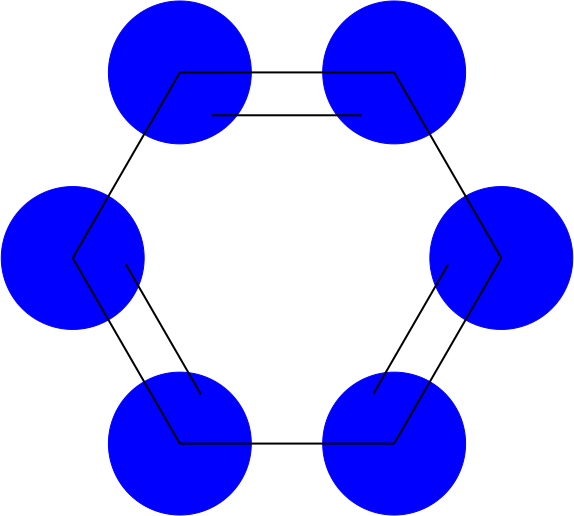

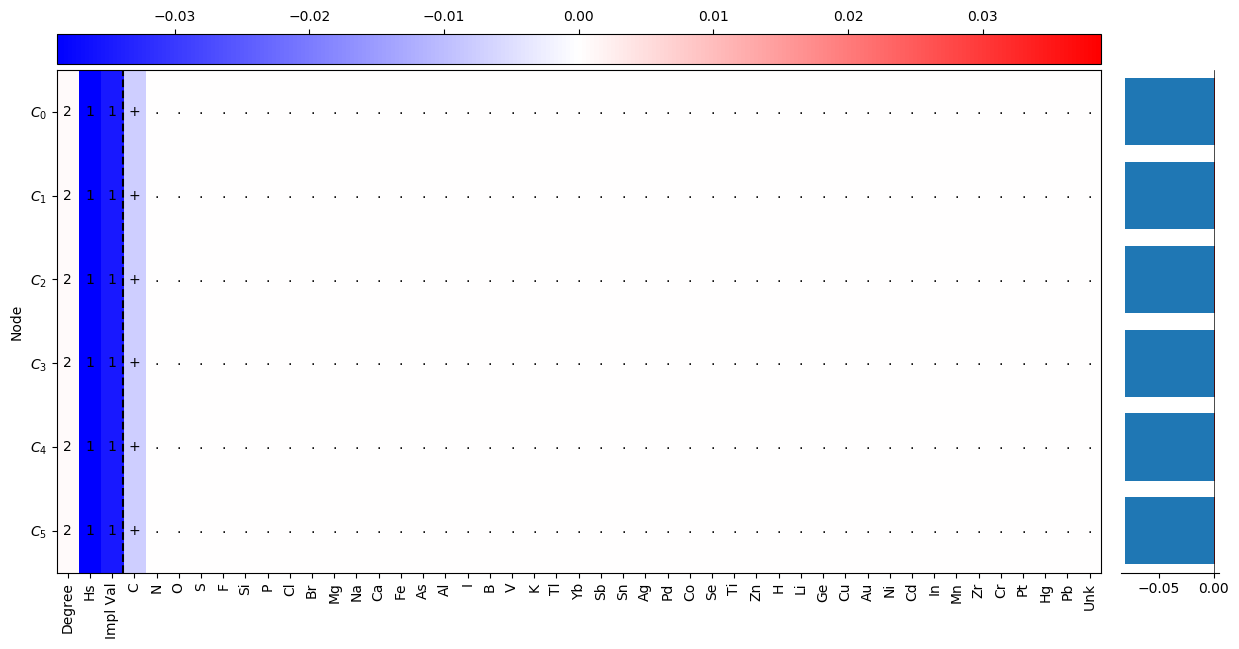

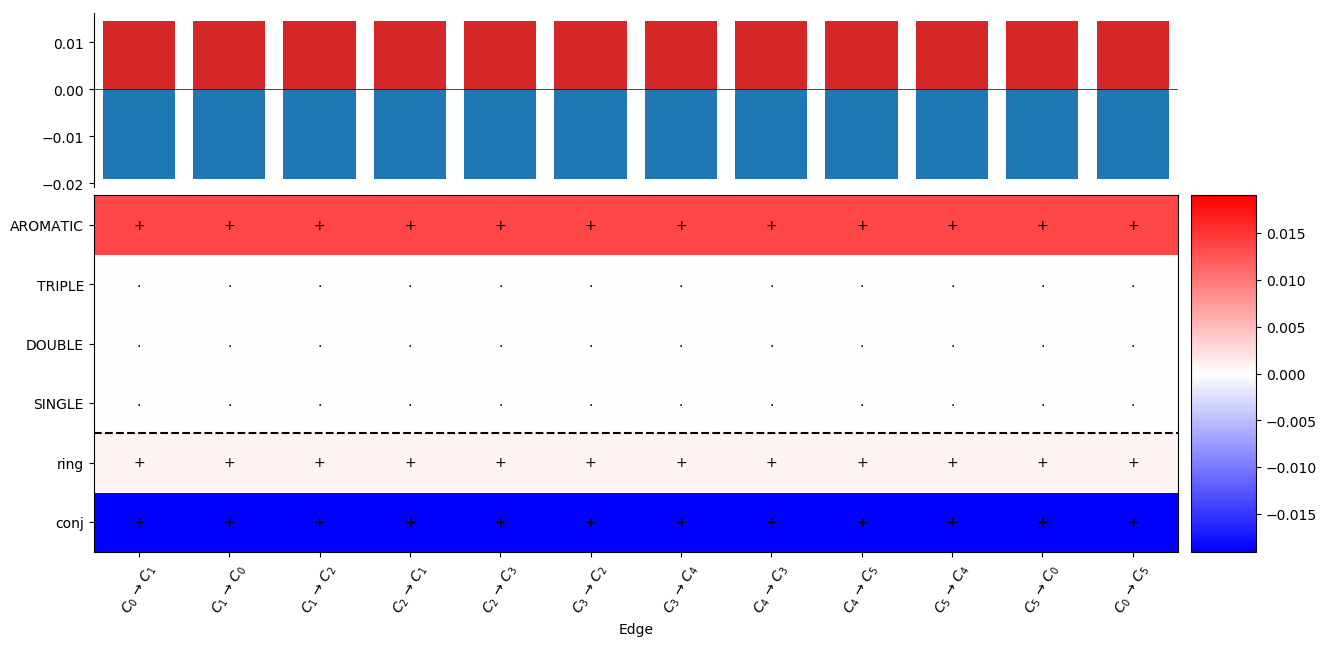

---

### c1cc(O)ccc1

nan	-0.33

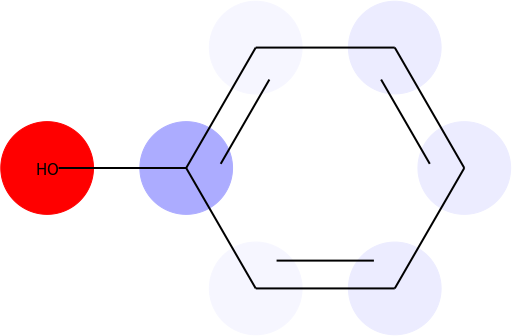

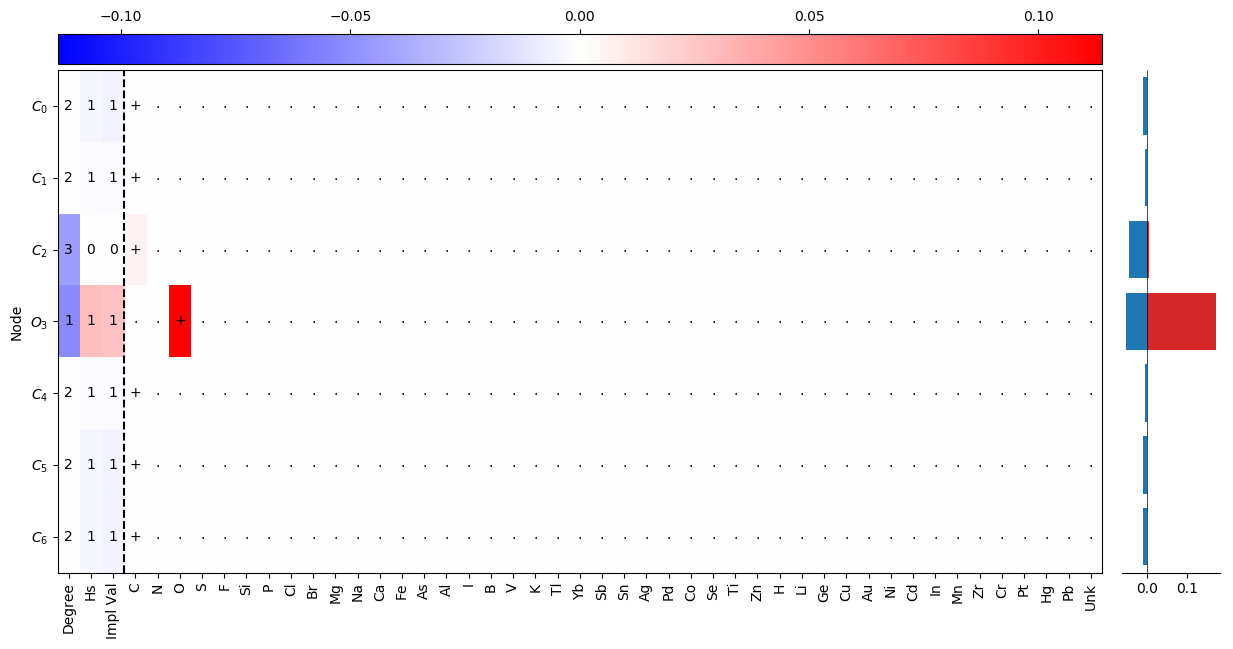

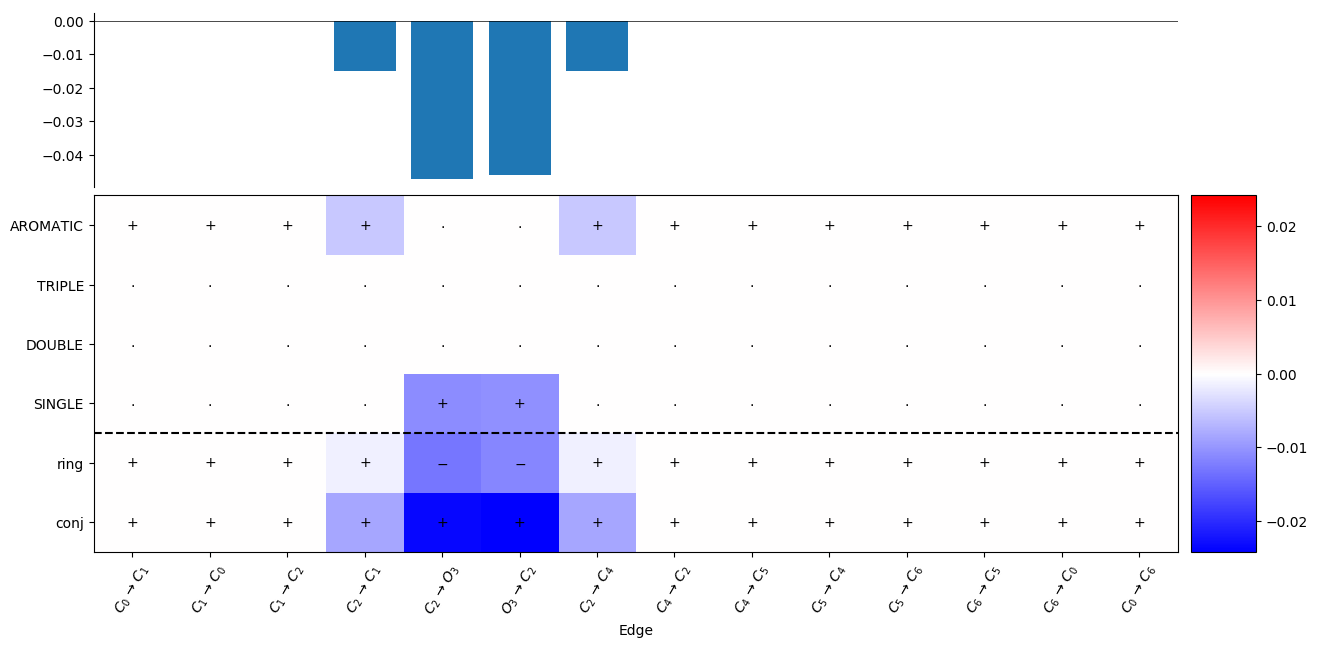

---

### CCCCC

nan	-2.4

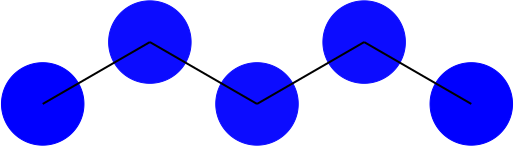

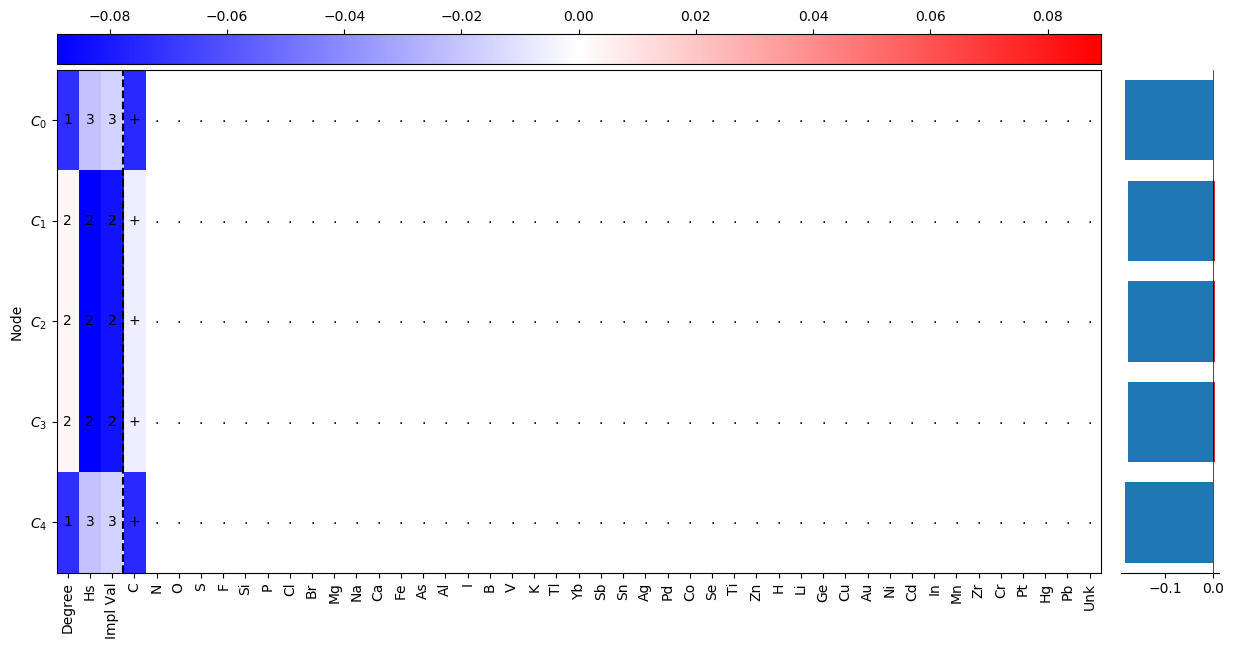

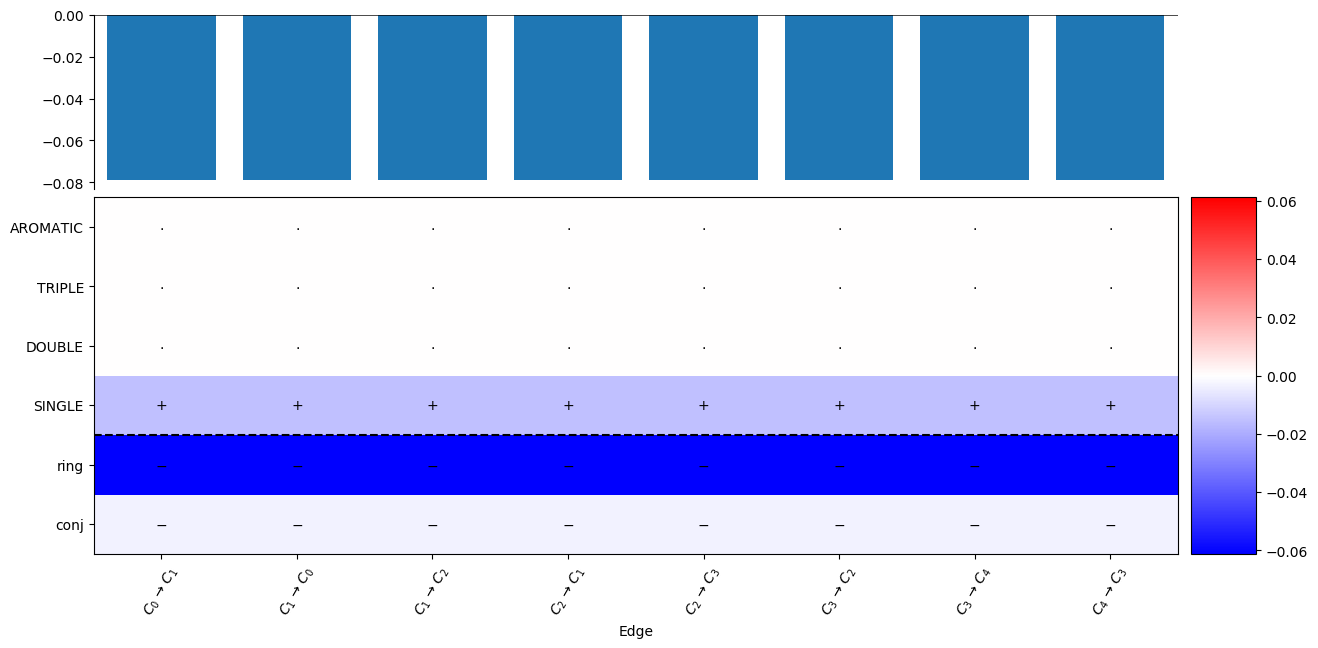

---

### CCC(=O)CC

nan	-0.63

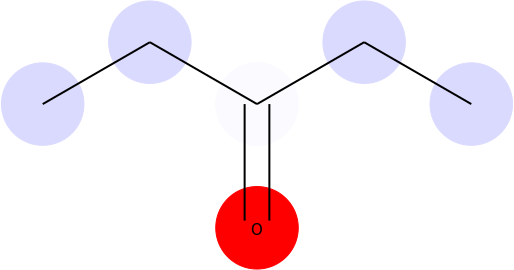

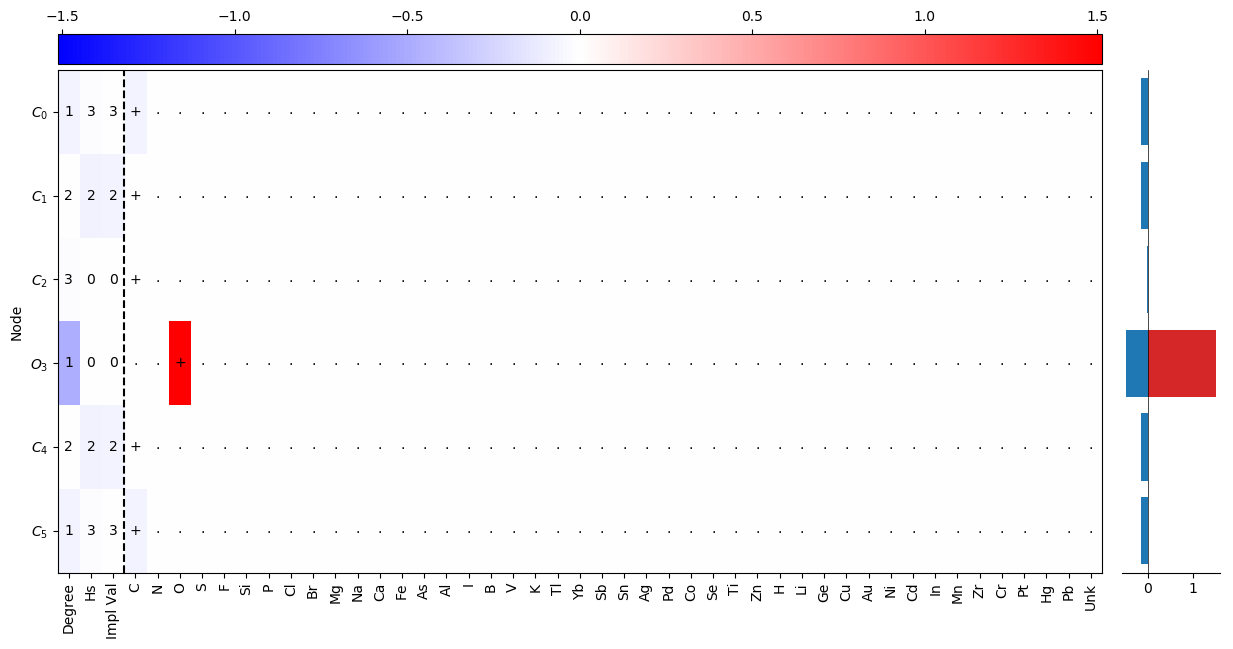

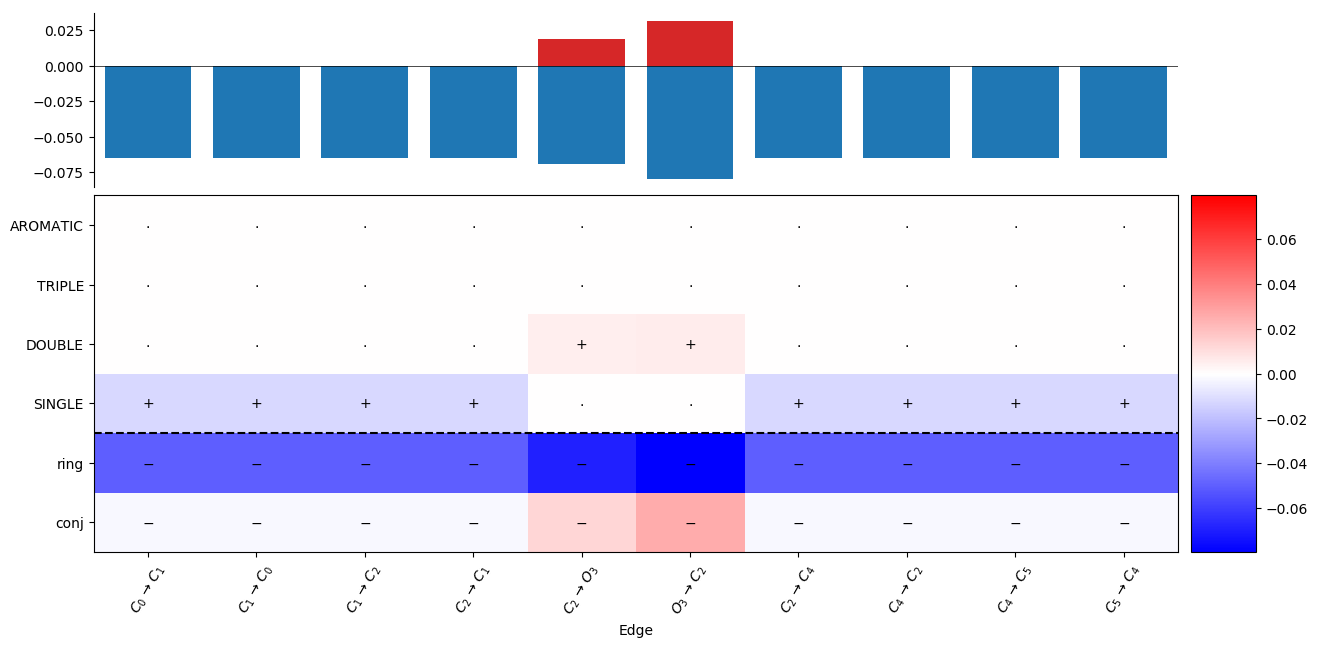

---

### CC(=O)C(=O)C(=O)C

nan	-0.23

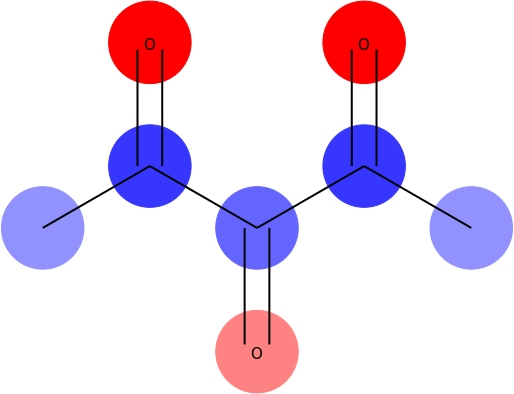

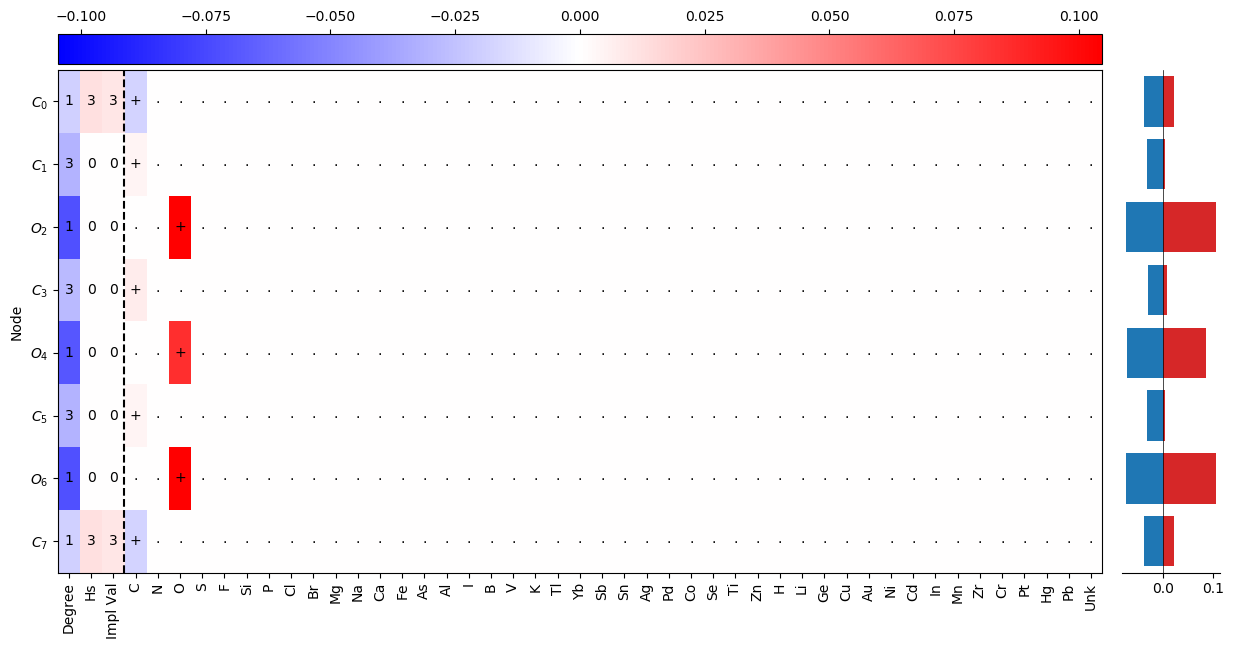

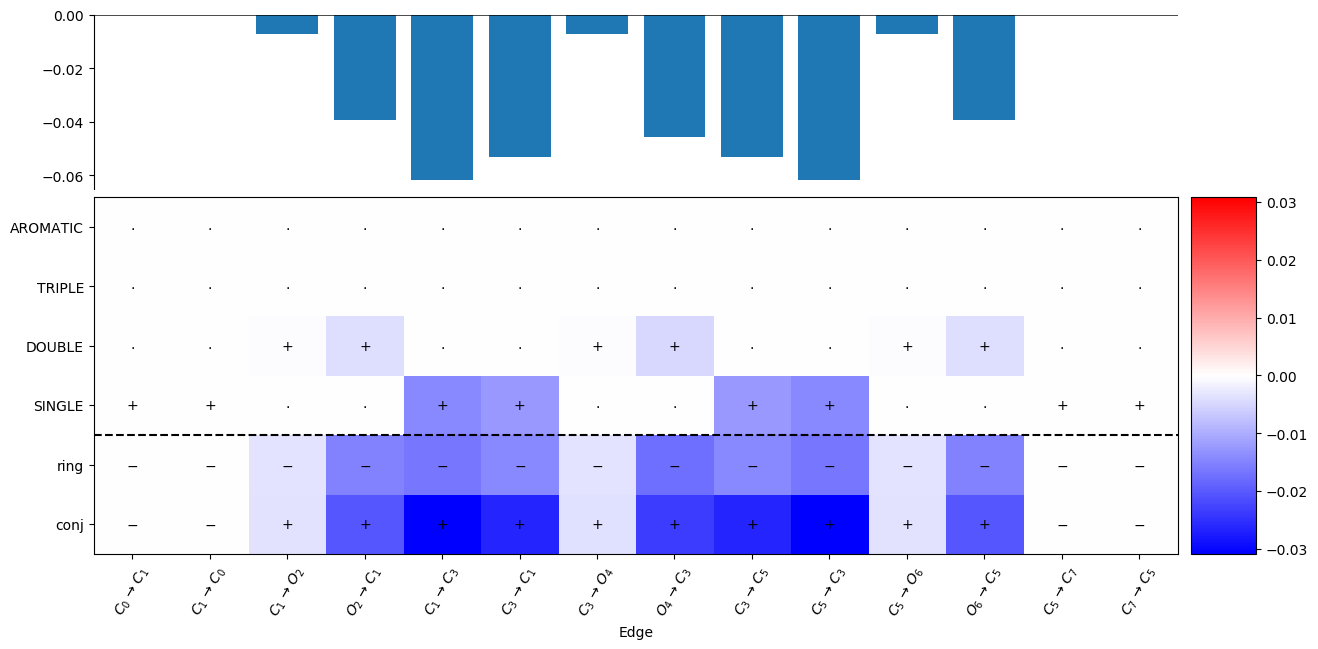

---

### CC(=O)C(O)C(=O)C

nan	0.23

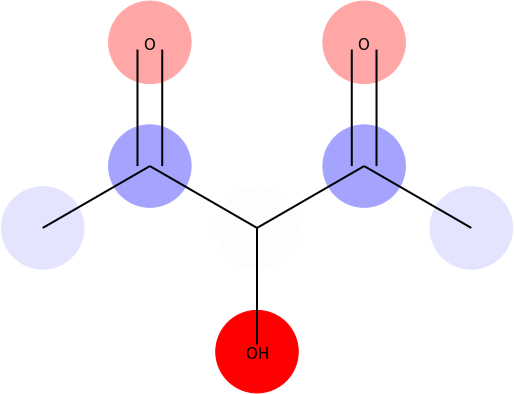

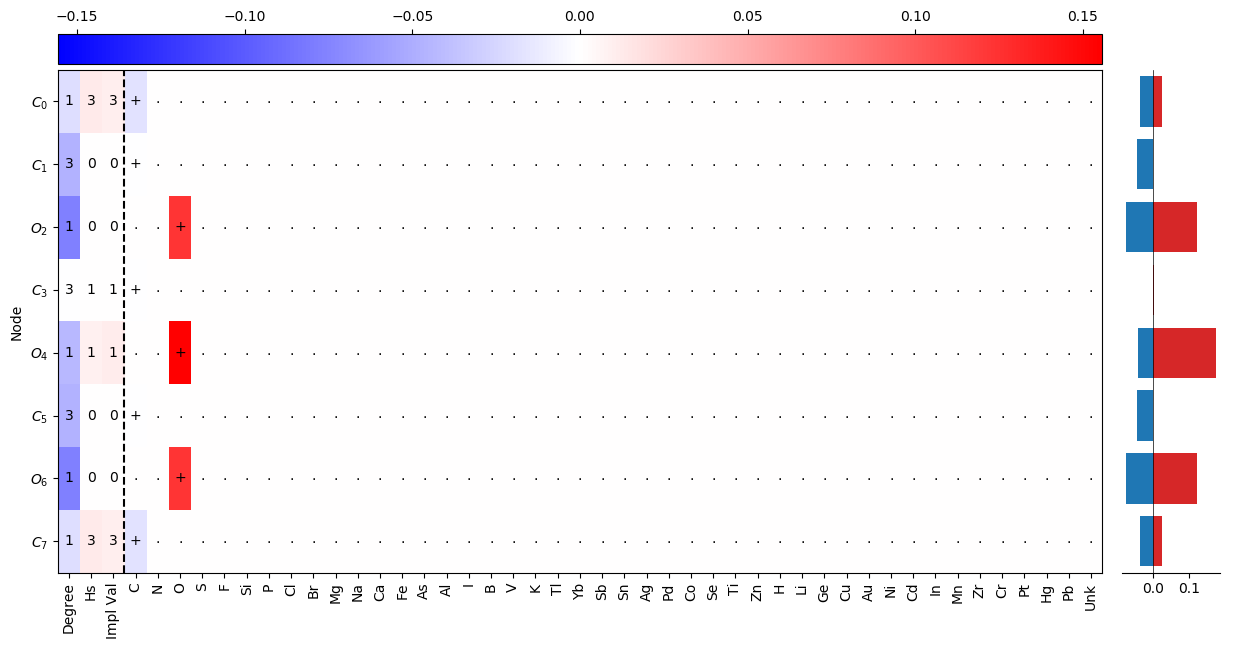

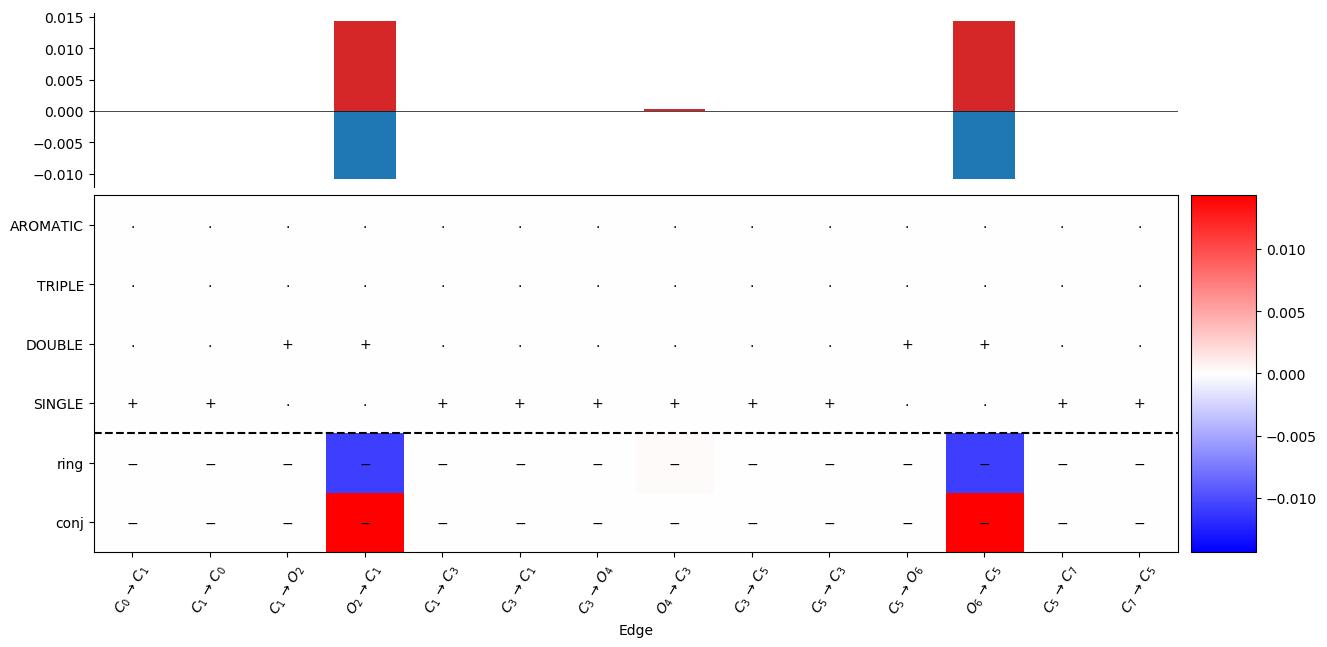

---

### CC(O)C(O)C(O)C

nan	0.66

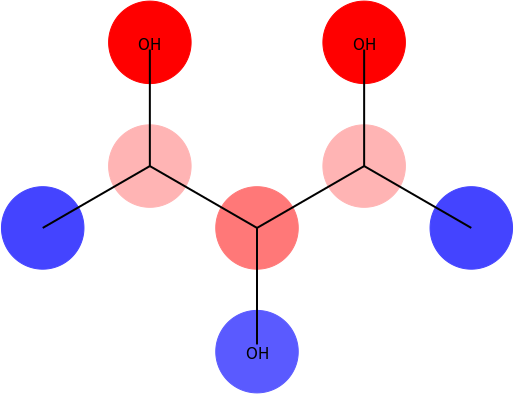

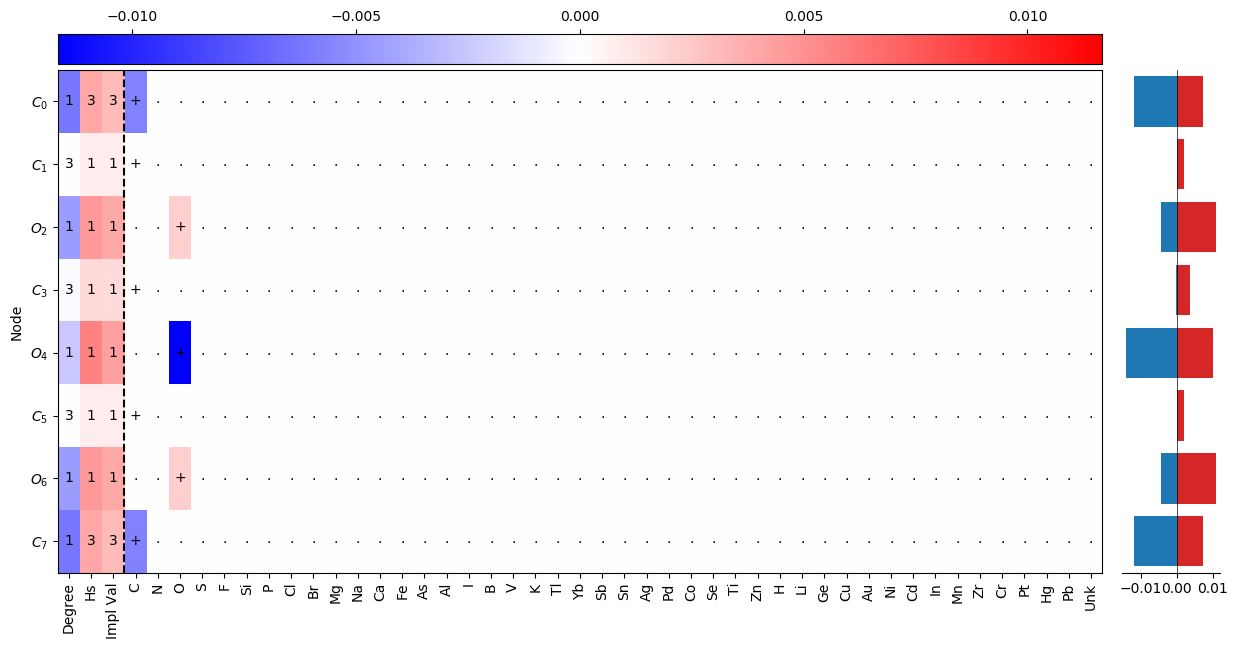

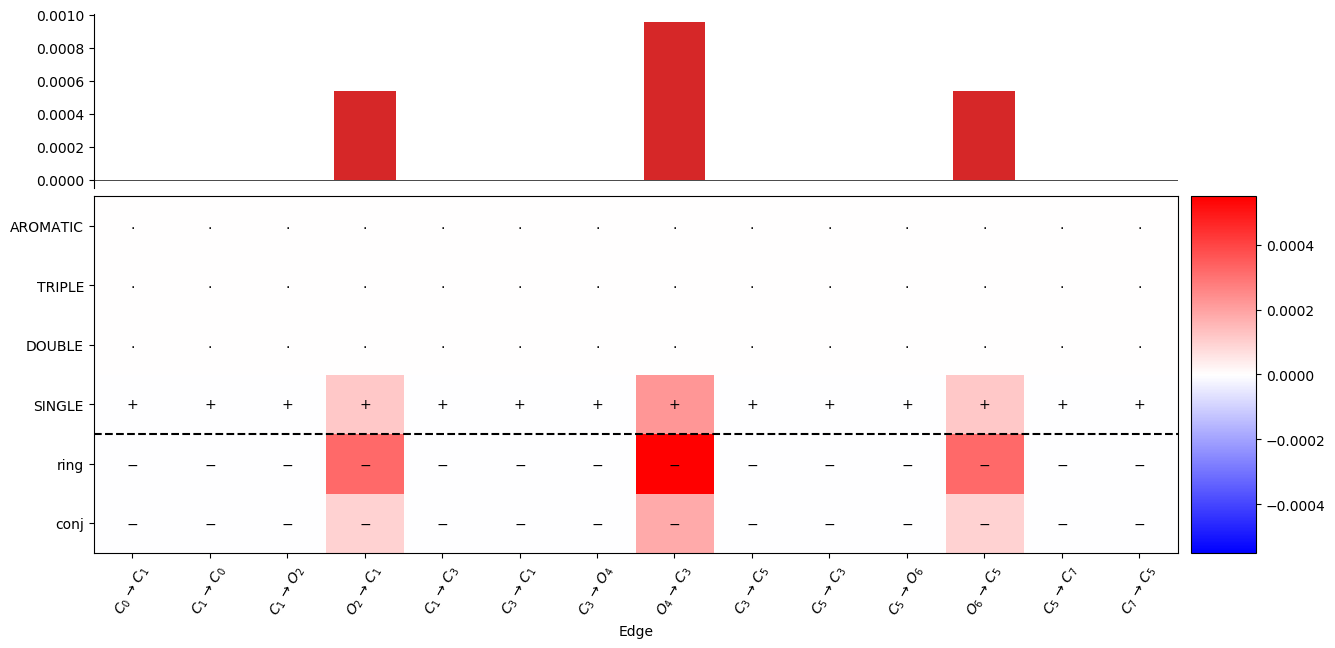

---

### 3-Hexanol

-0.800000011920929	-0.8

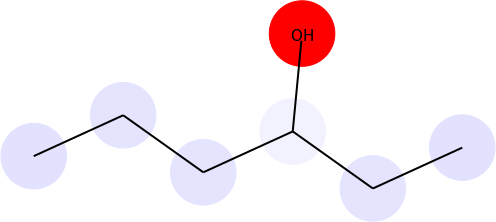

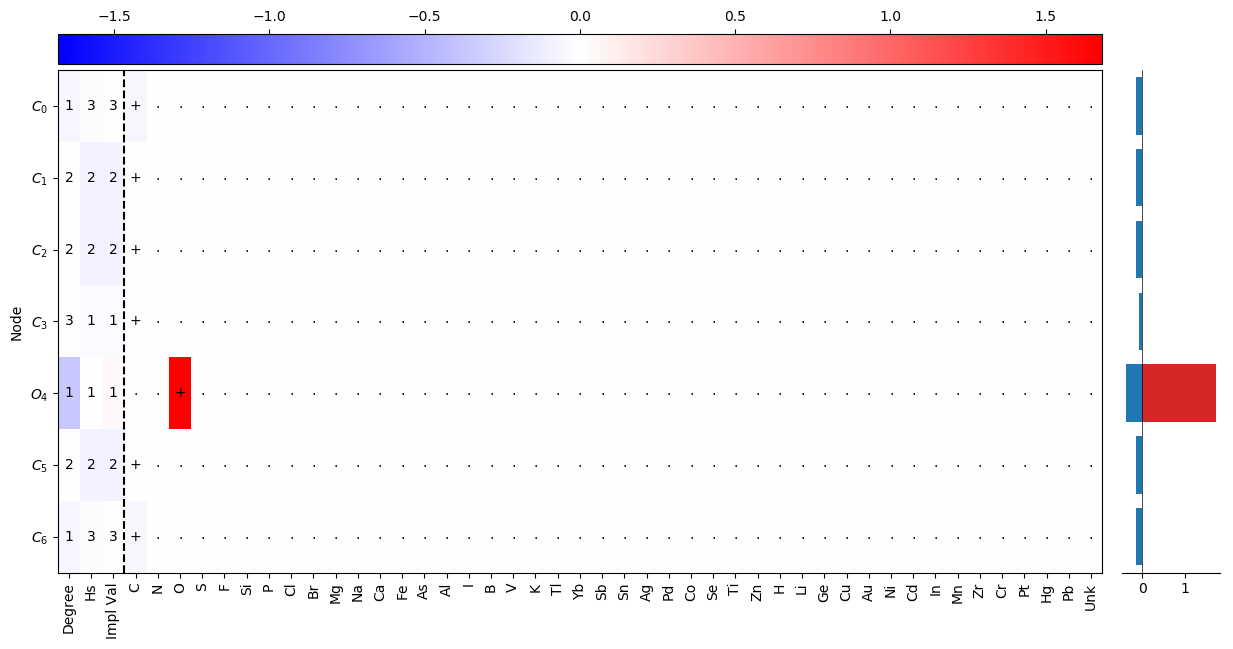

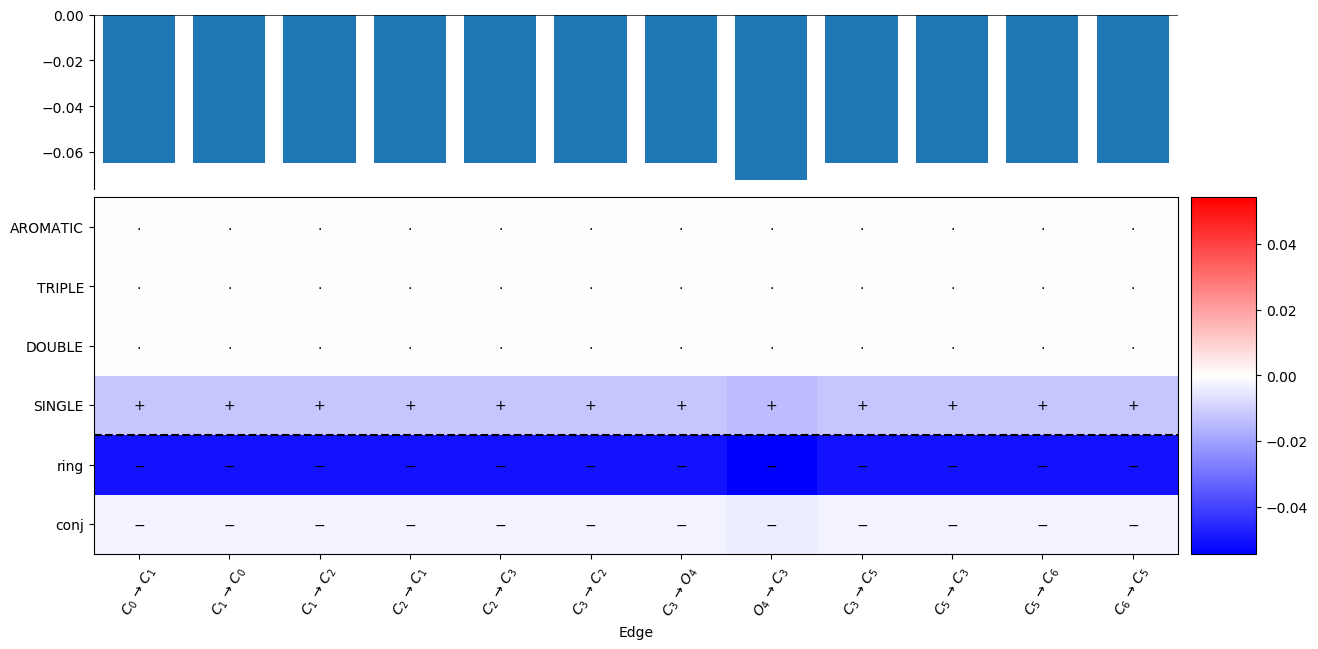

---

### 3-Methyl-3-pentanol

-0.36000001430511475	-0.85

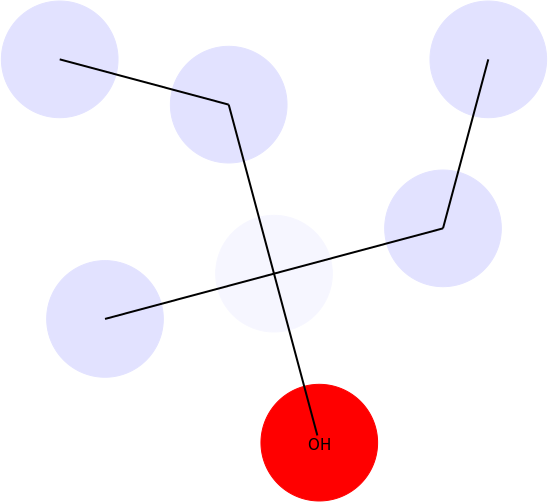

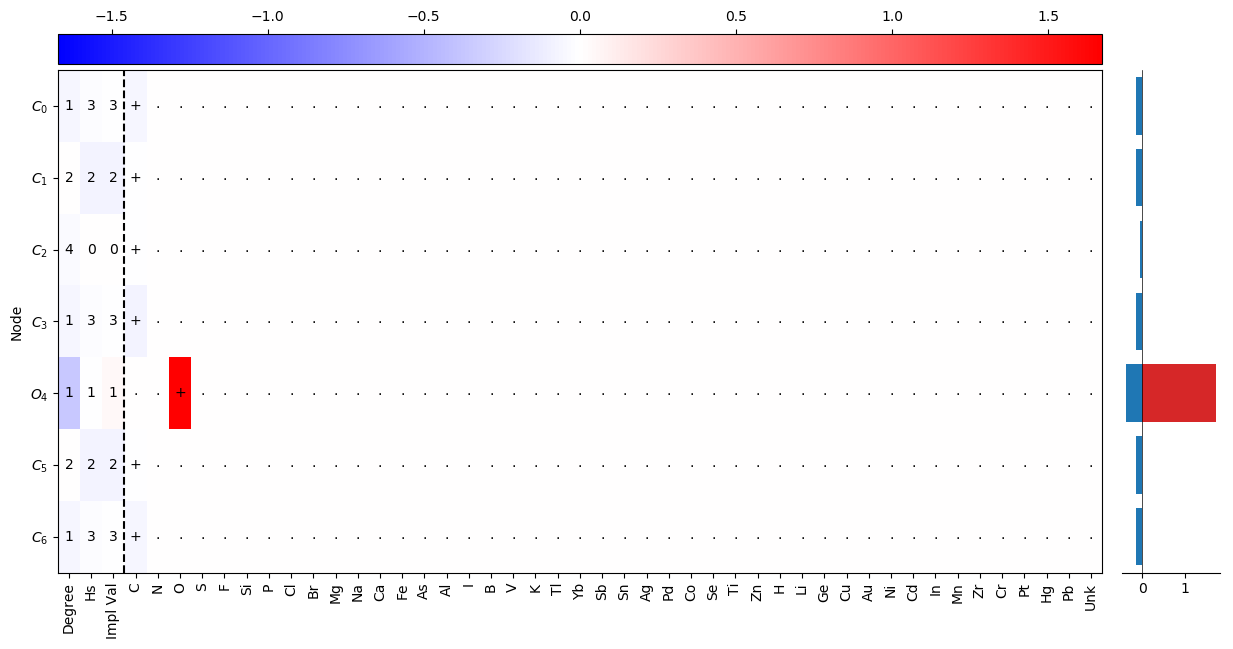

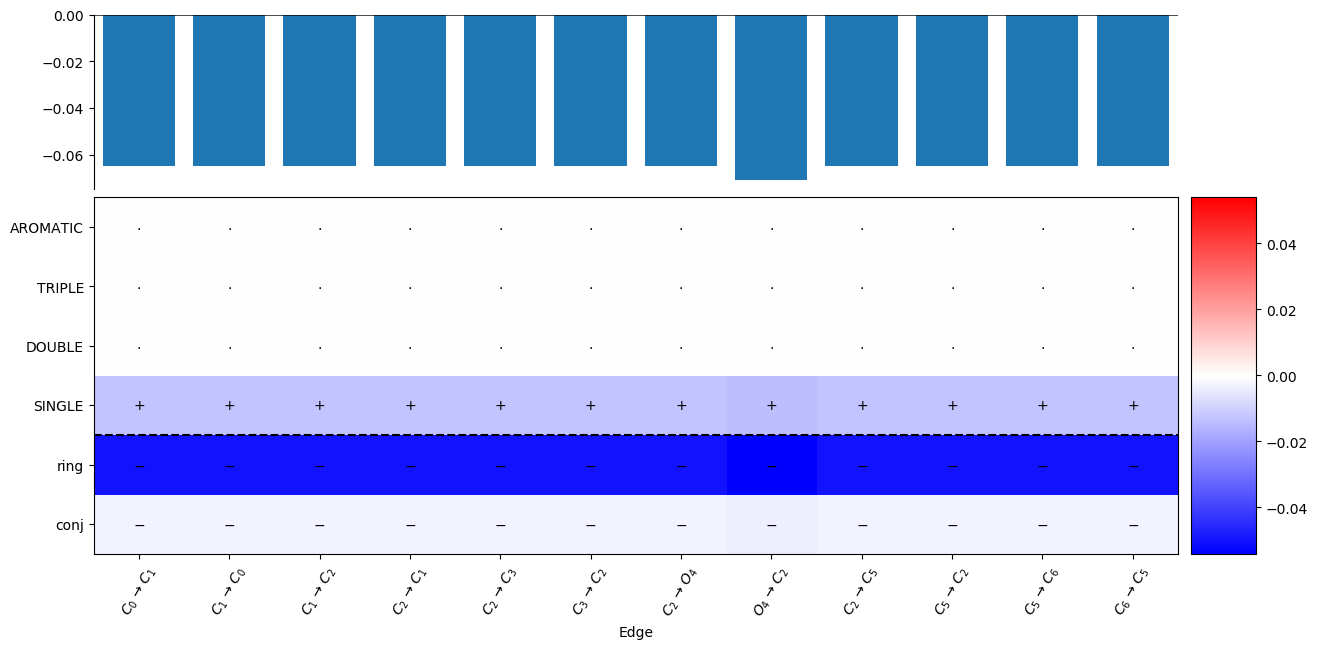

---

### Benzo[ghi]perylene

-9.020000457763672	-8.97

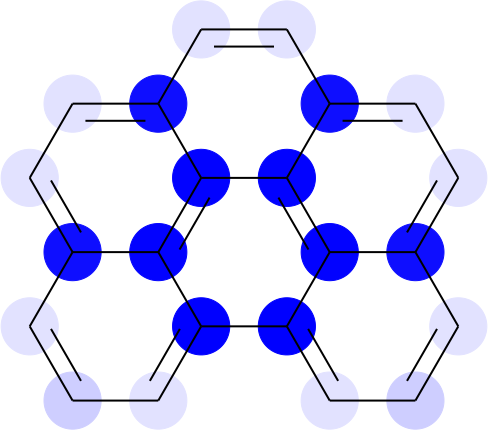

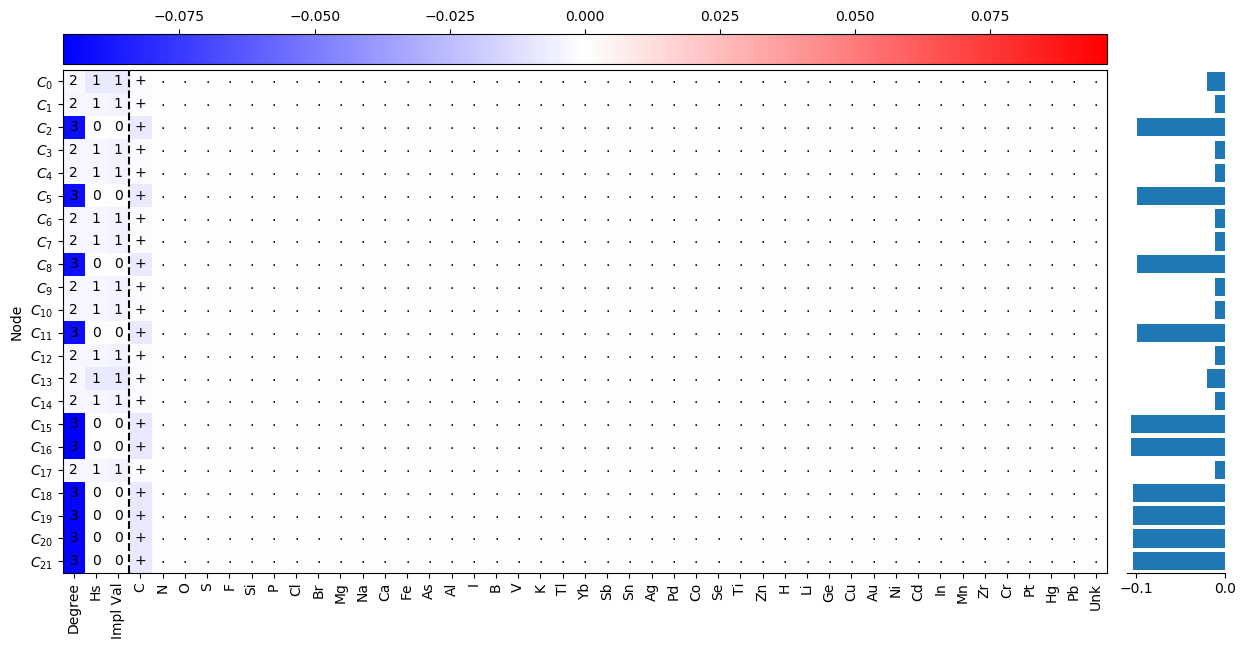

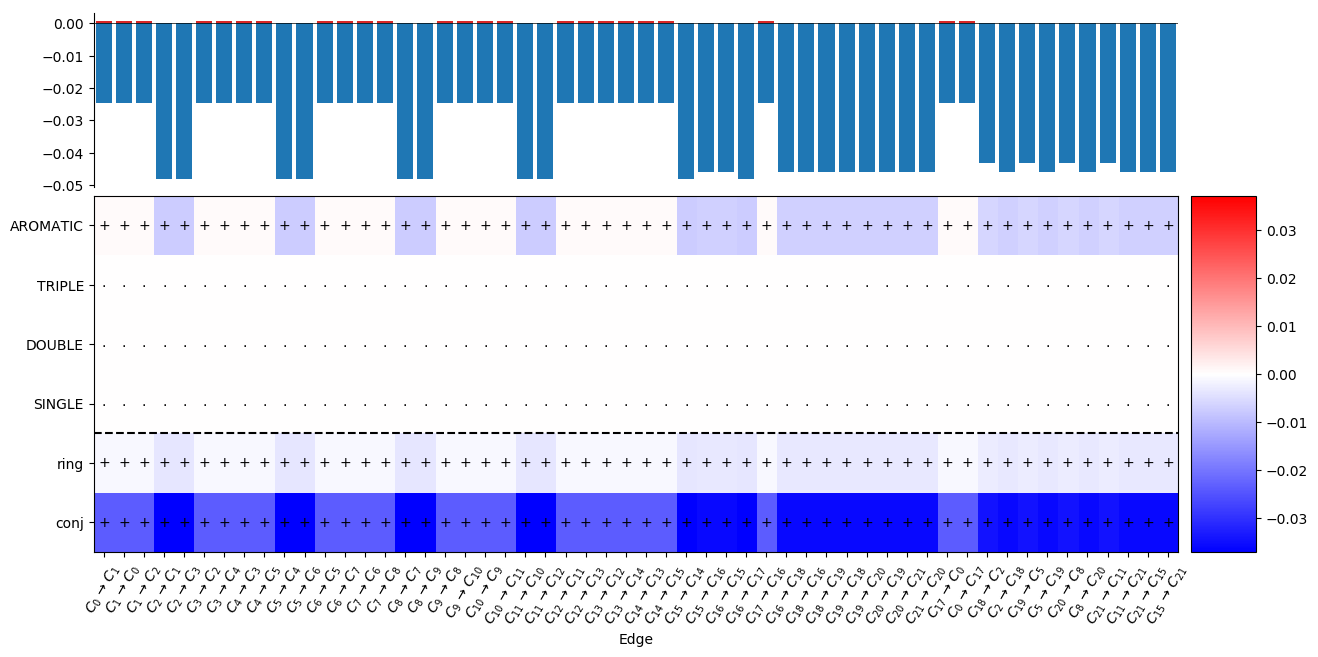

---

### Perylene

-8.800000190734863	-7.92

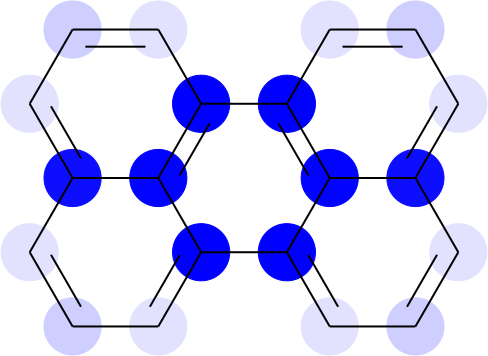

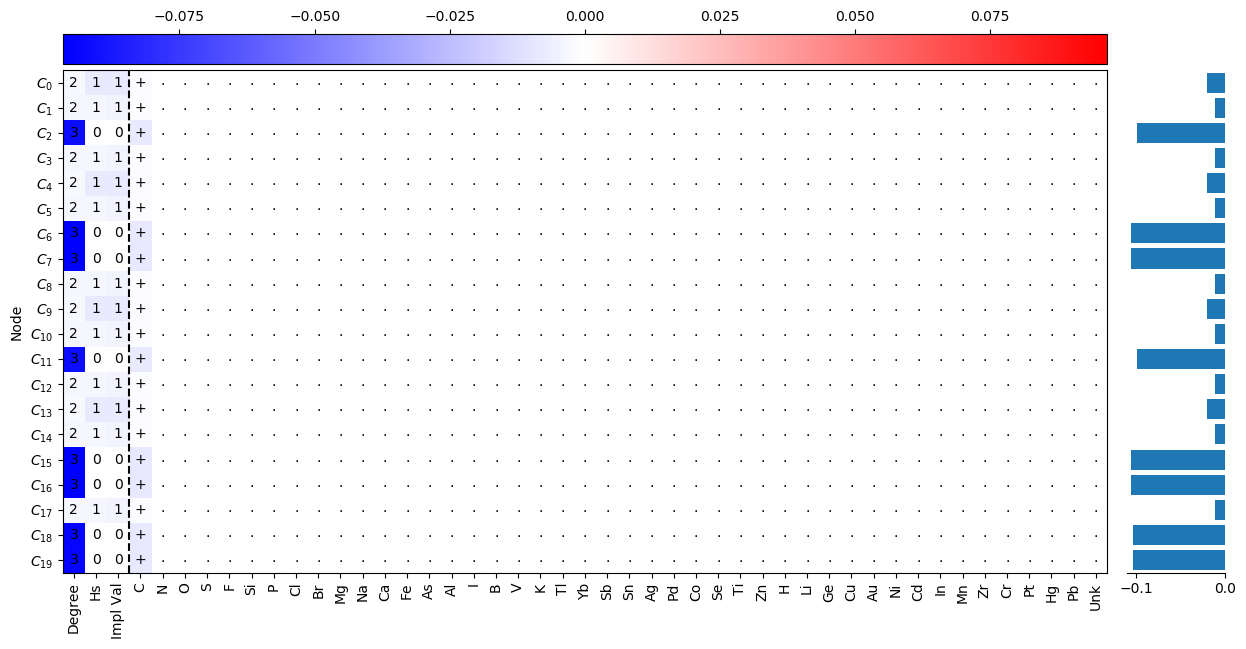

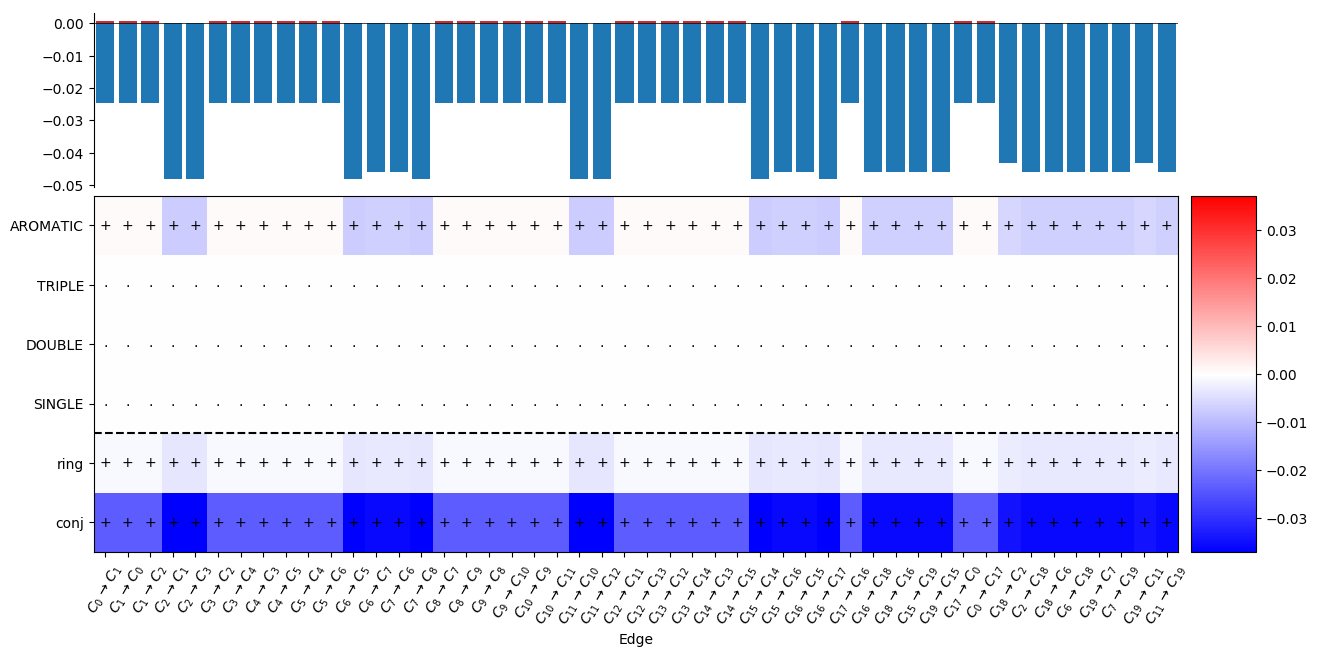

---

### 2,2',3,3',4,4',5,5',6,6'-PCB

-11.600000381469727	-10.93

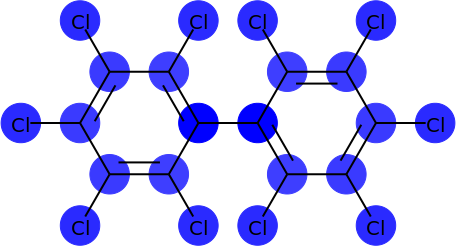

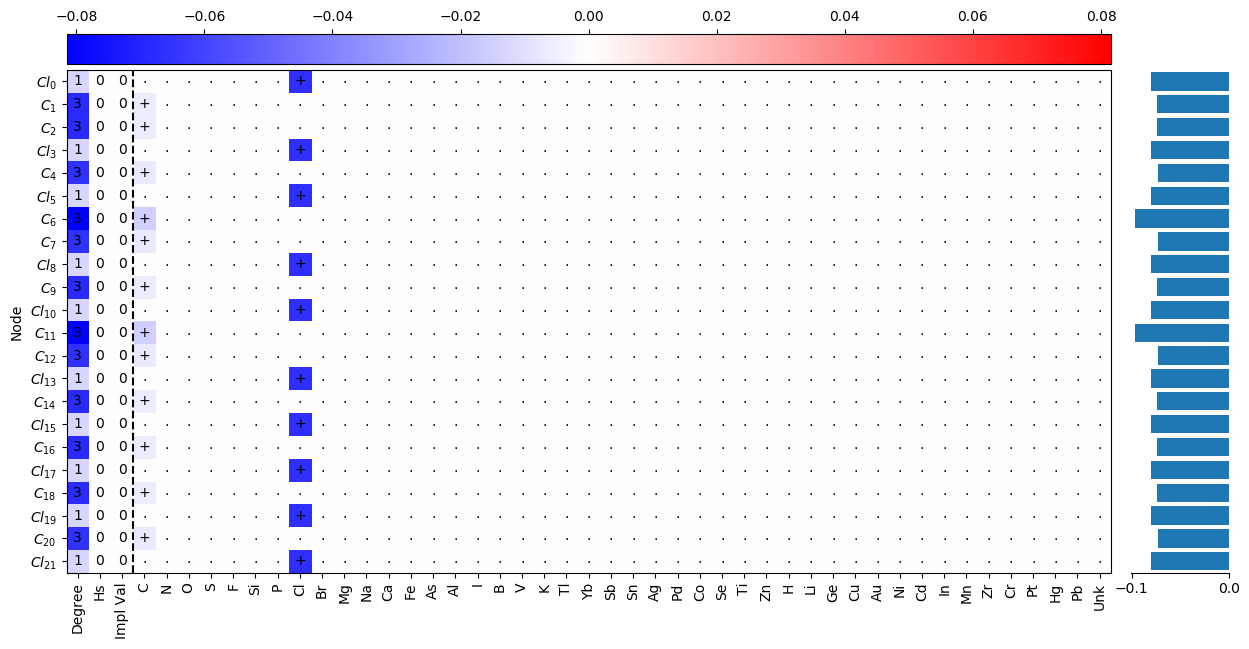

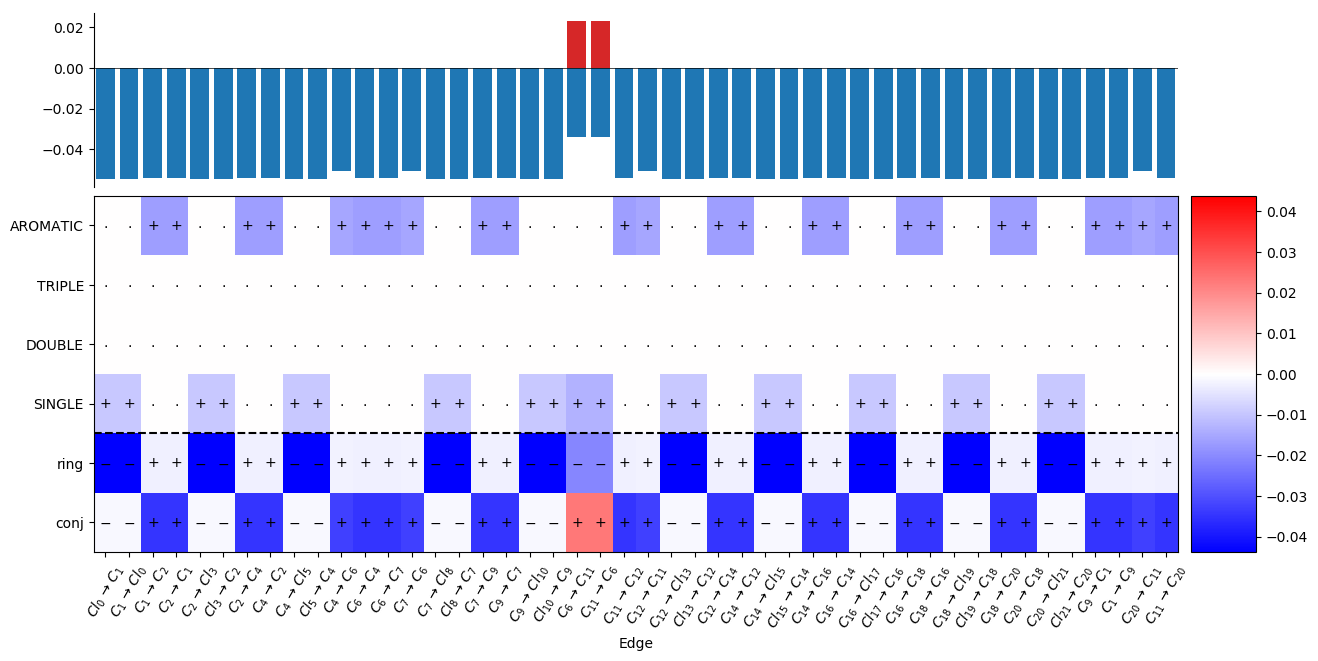

---

### Acetamide

1.5800000429153442	0.37

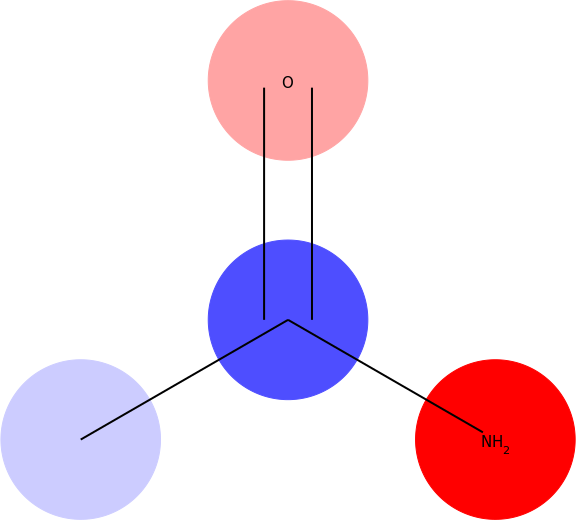

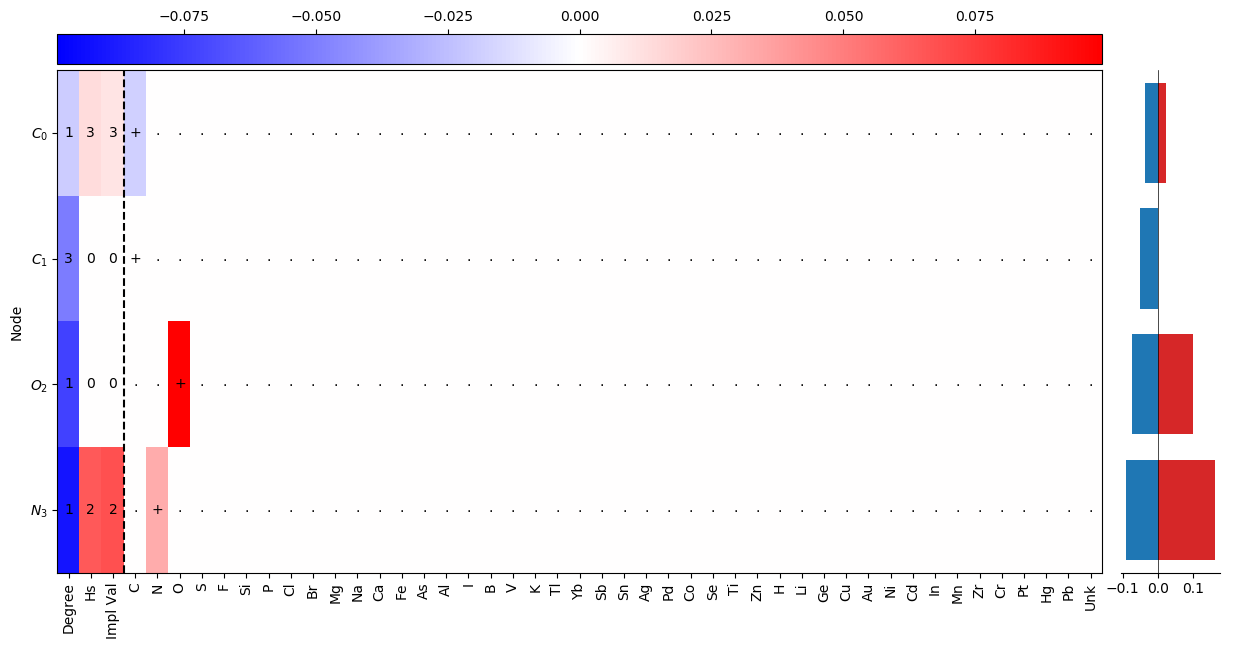

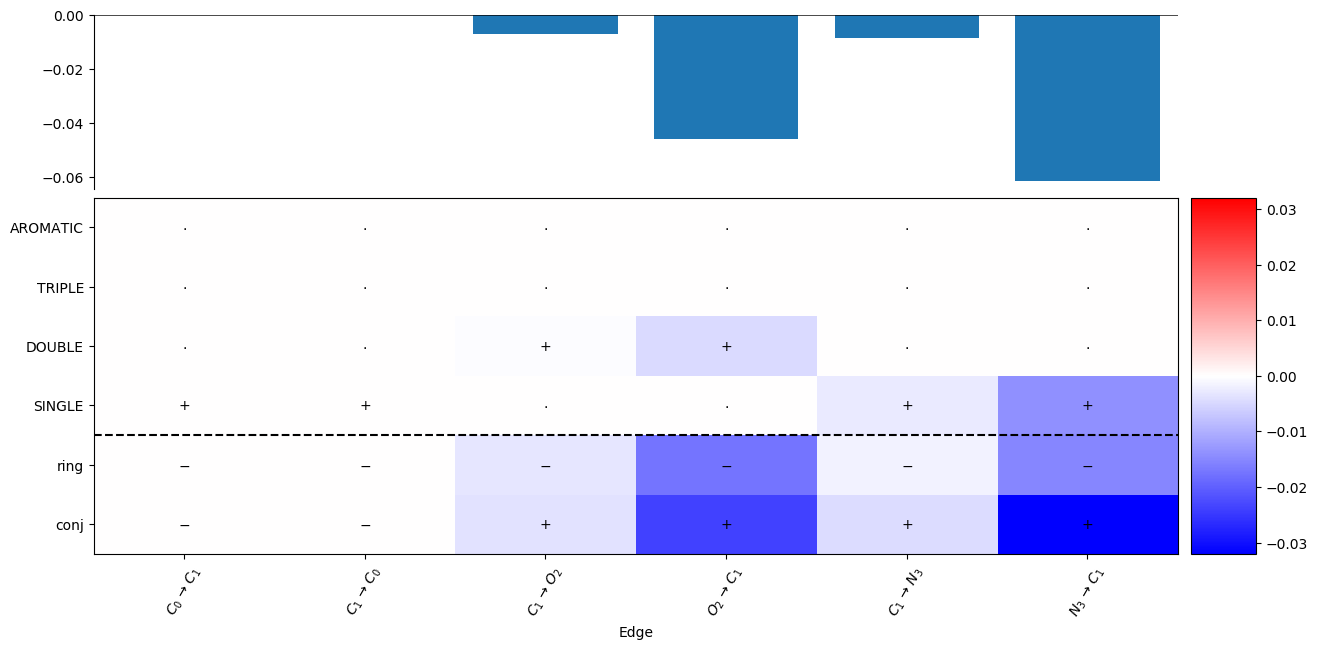

---

### vamidothion

1.1399999856948853	-2.37

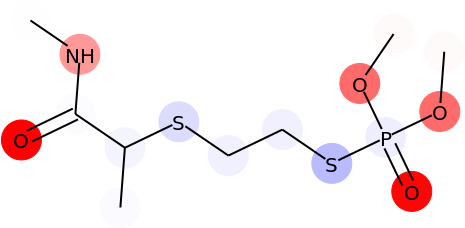

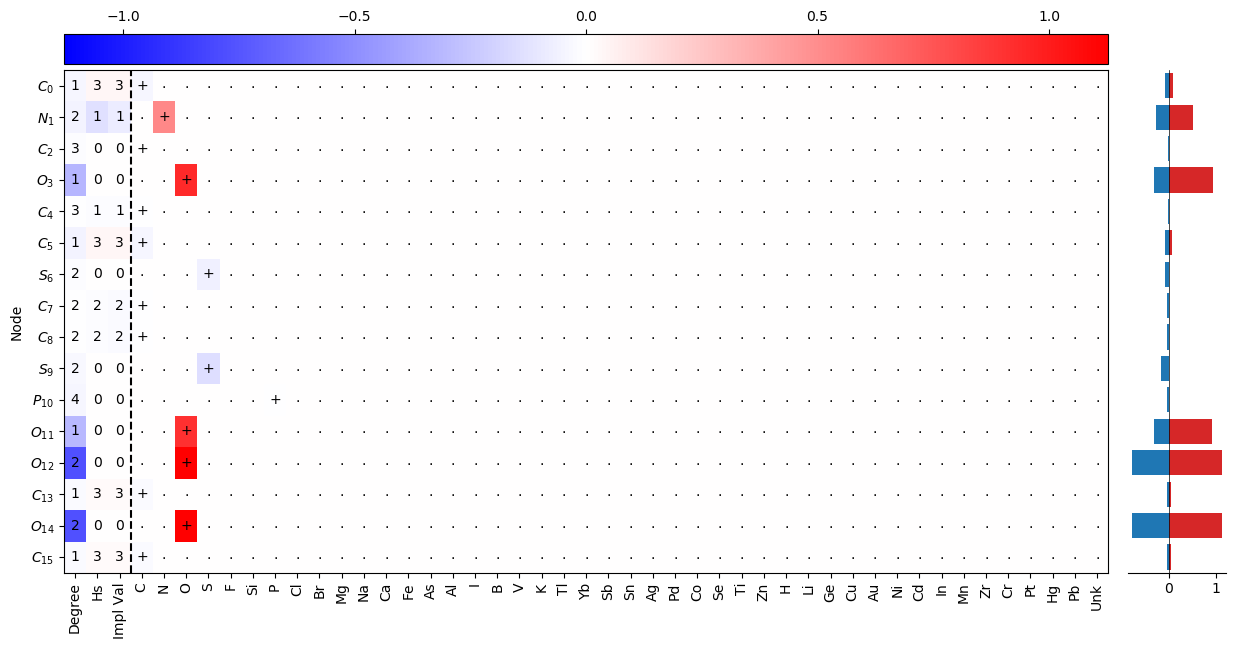

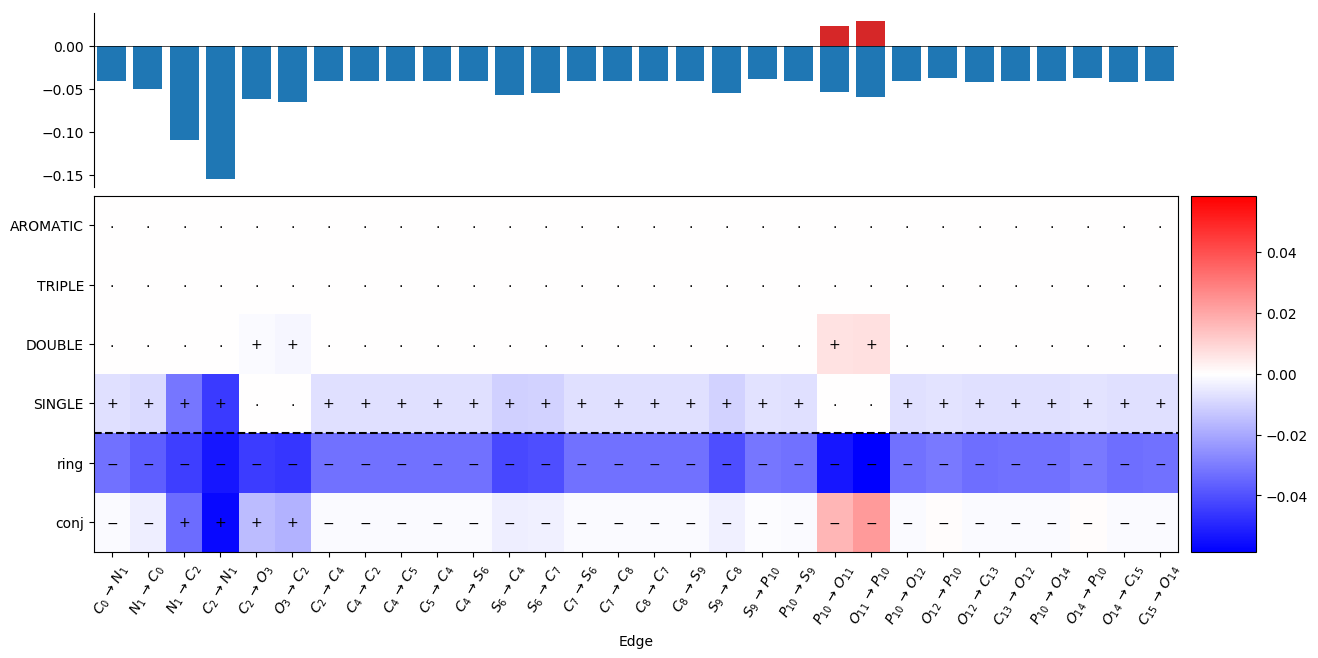

---

### tetramethylurea

0.9399999976158142	-0.08

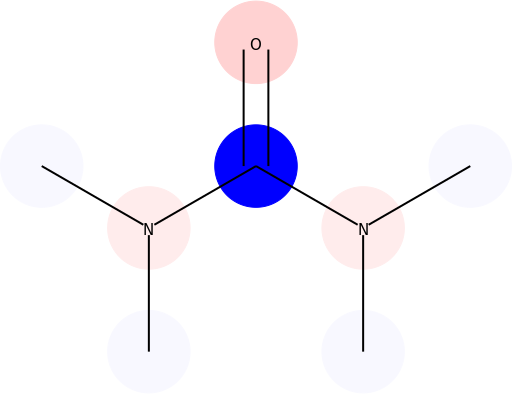

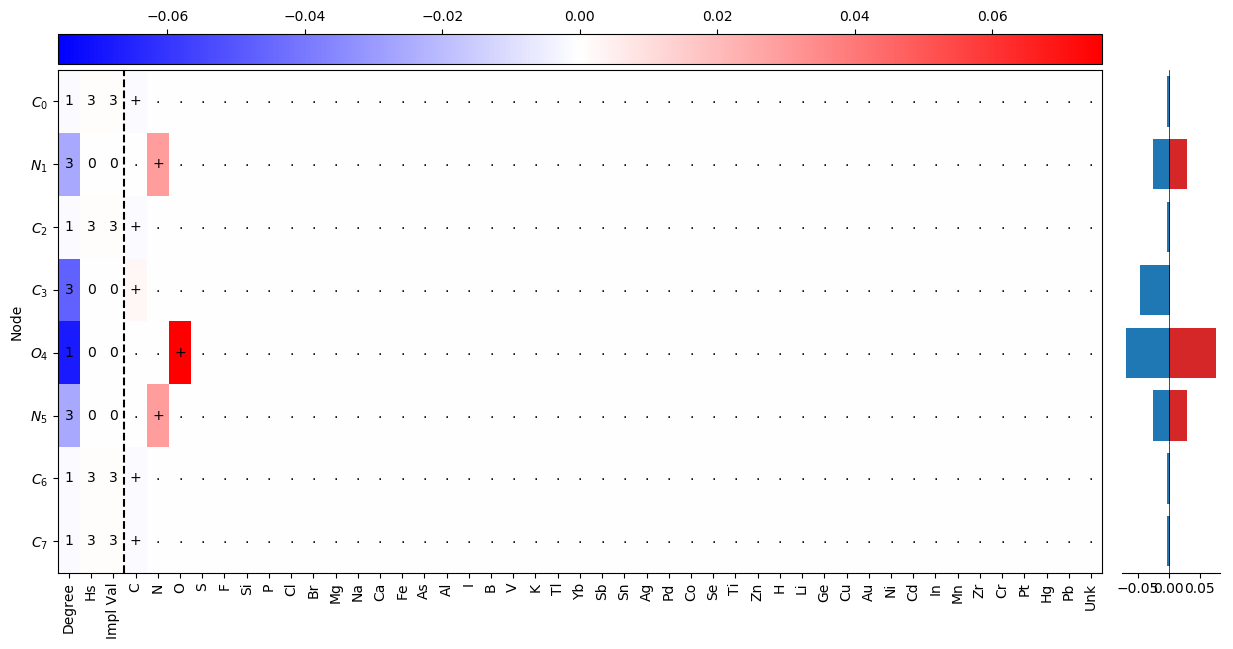

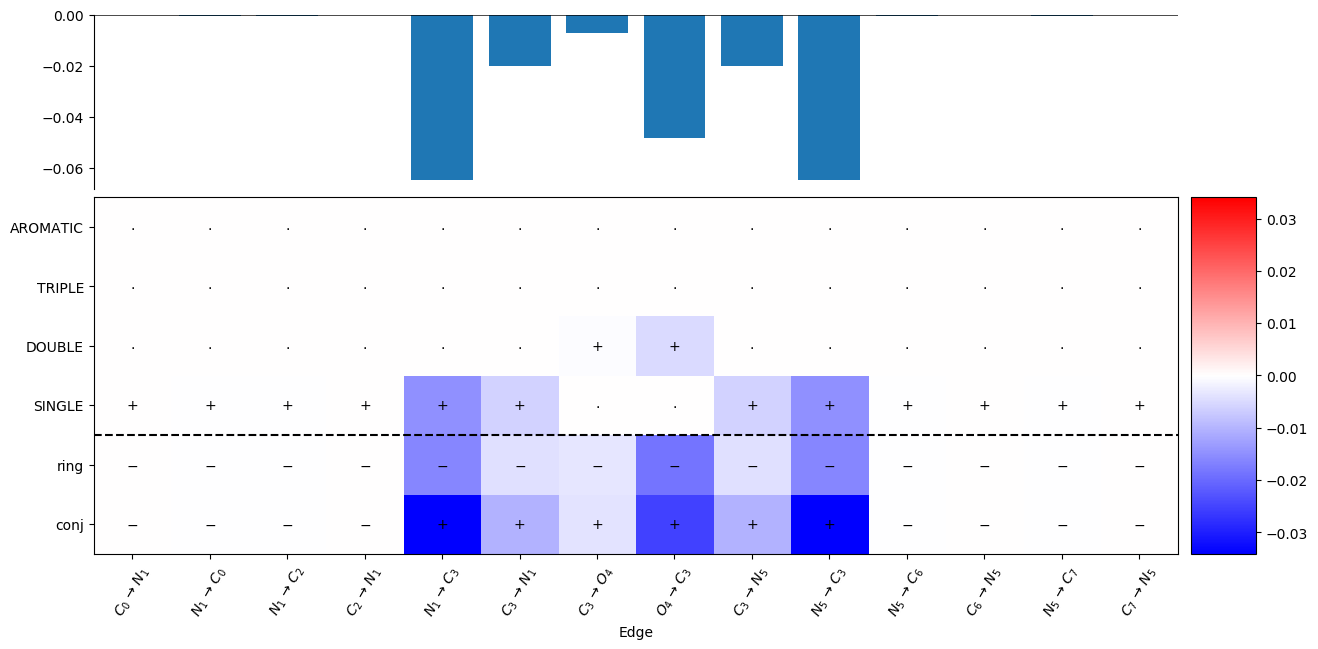

---

### O-Ethyl carbamate

0.8500000238418579	-0.02

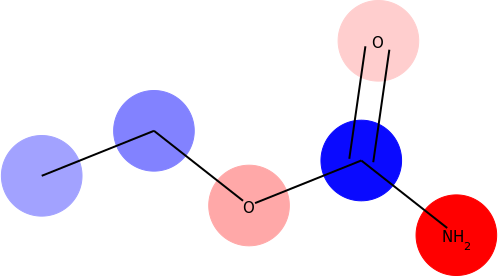

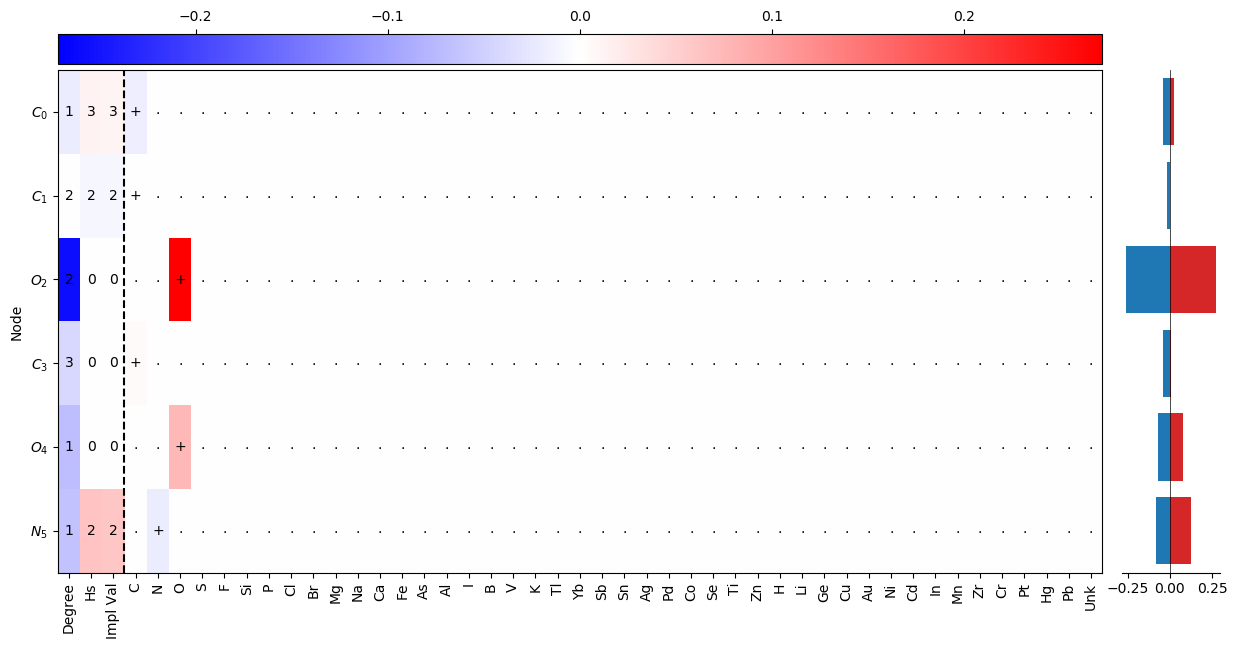

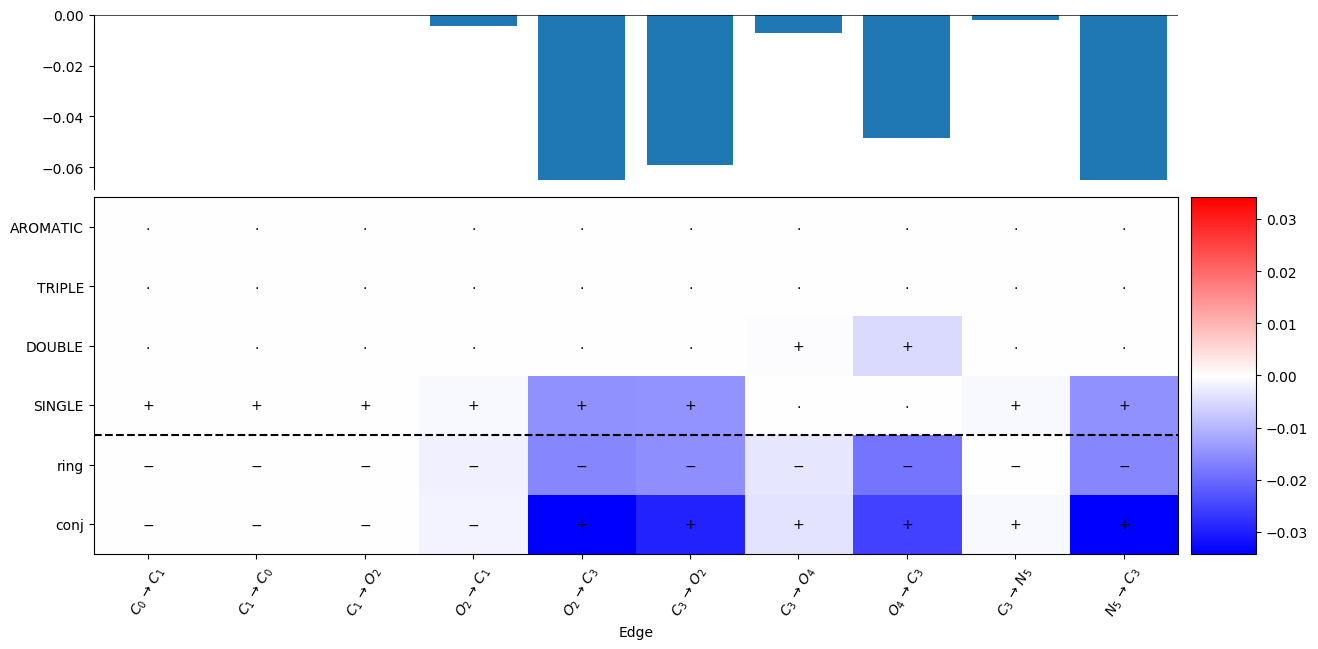

---

### glucose

0.7400000095367432	0.67

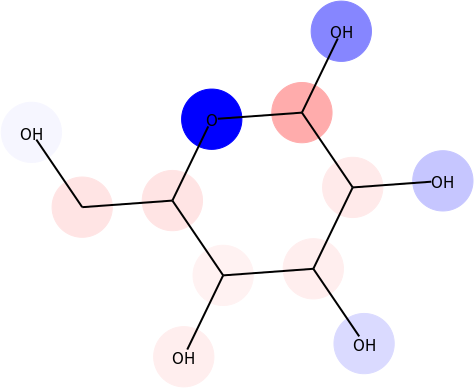

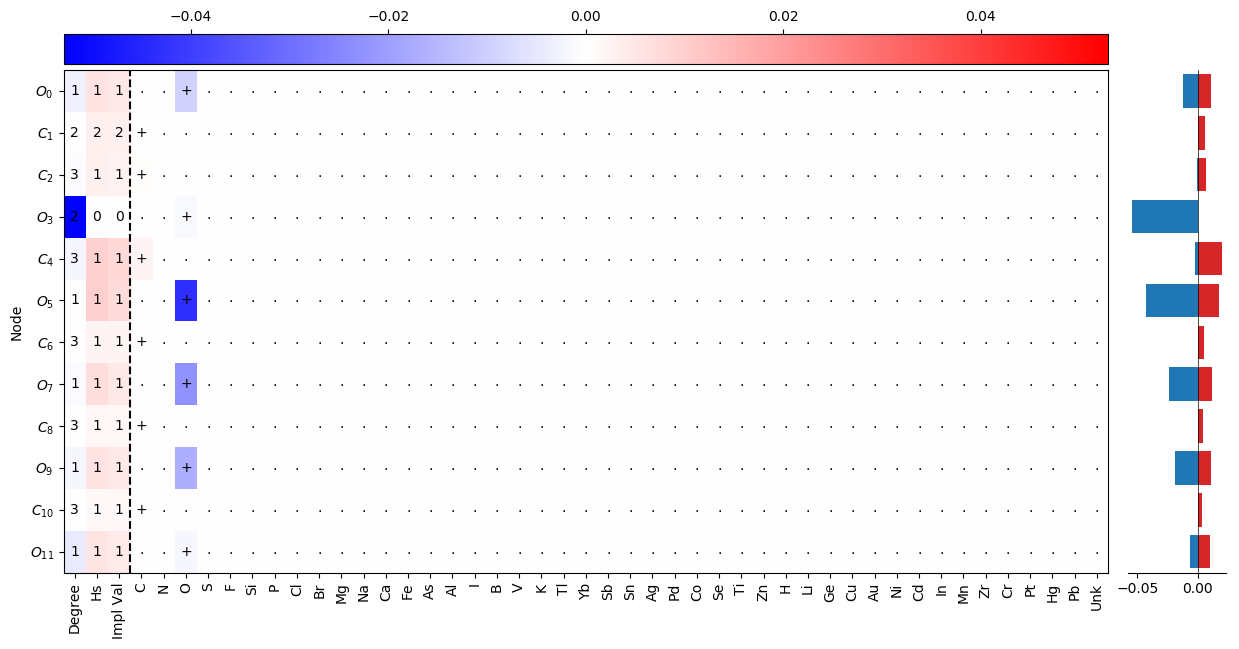

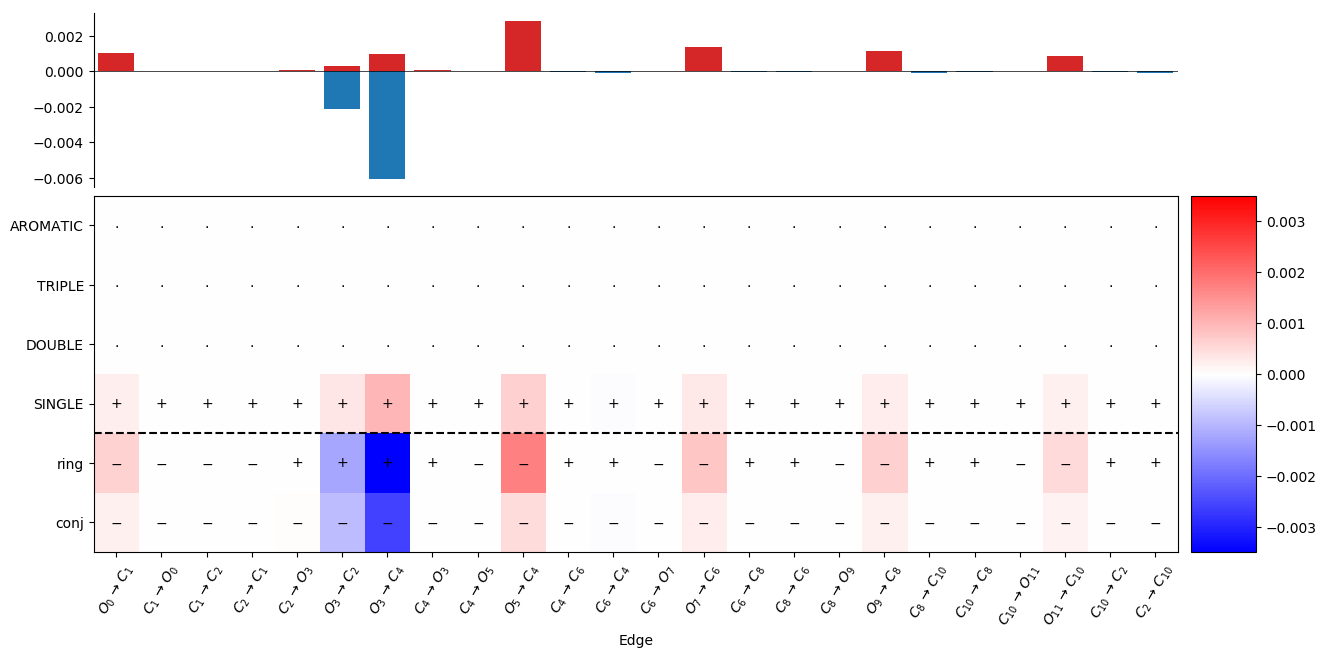

---

### 4-hexylresorcinol

-2.5899999141693115	-2.54

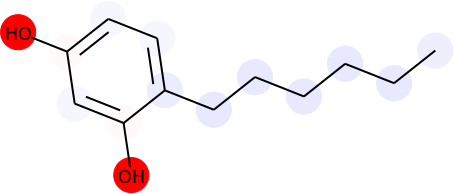

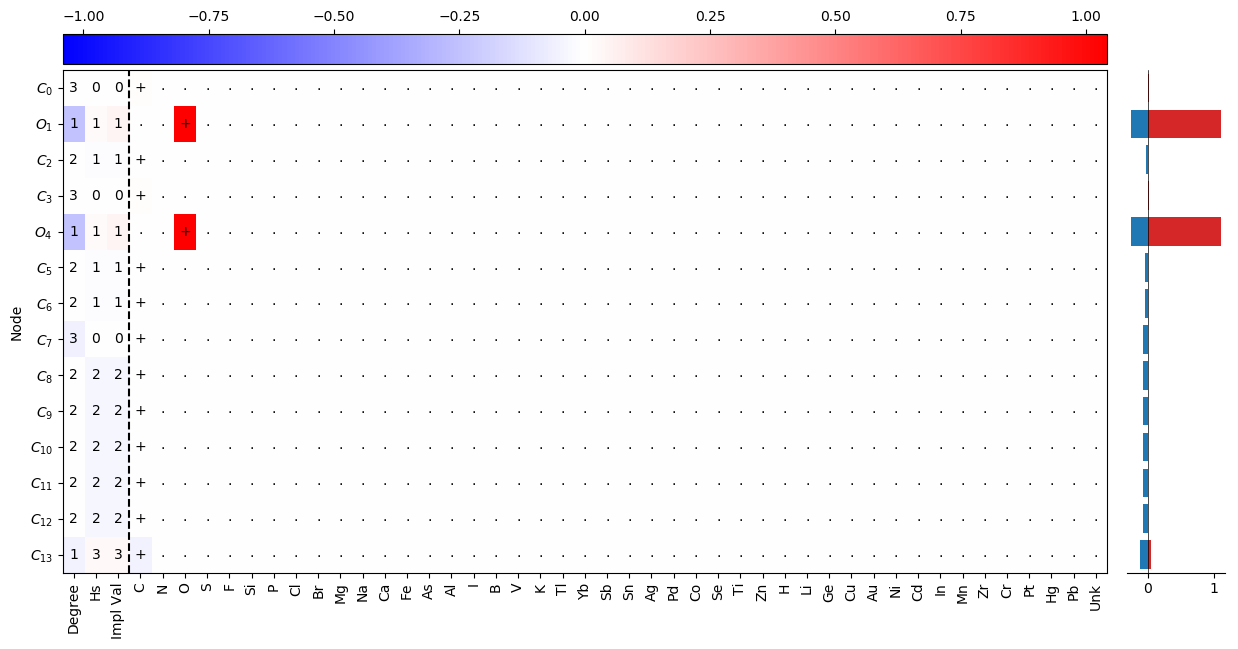

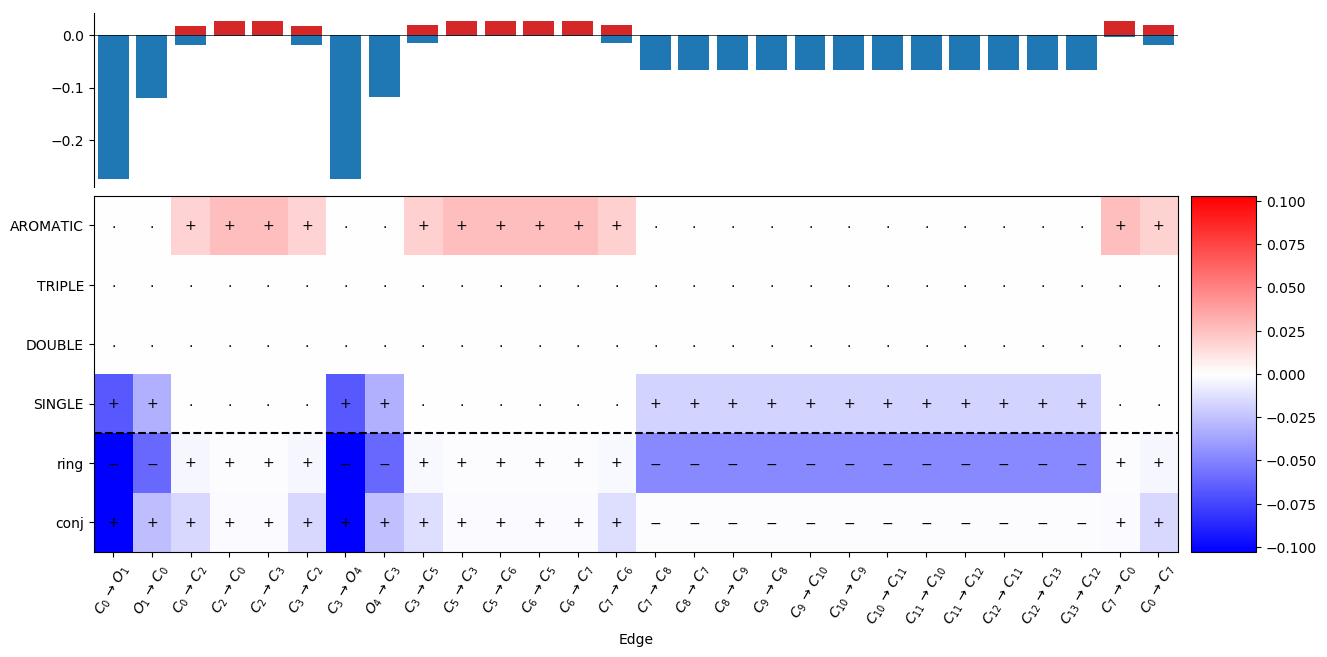

---

In [11]:
mysmiles = [
    'CCCCCCCCCCCCCCCCCC(=O)O', # stearic acid
    'C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O', # sucrose
    'c1ccccc1',
    'c1cc(O)ccc1',
]
quantitative = [ # from less soluble to more soluble
    'CCCCC',
    'CCC(=O)CC',
    'CC(=O)C(=O)C(=O)C',
    'CC(=O)C(O)C(=O)C',
    'CC(O)C(O)C(O)C',
]
papersmiles = [
    388, # from the paper, high sol
    446, # from the paper, high sol
    676, # from the paper, low sol
    220, # from the paper, low sol
]
someothers = [
    603,
    605,
    1064,
    1082,
    253,
    341,
    847
]

smiles = (
    mysmiles +
    quantitative +
    papersmiles +
    someothers +
    []
)

for sm in smiles:    
    if isinstance(sm, int):
        name = ds.df['Compound ID'][sm]
        graph_in, solubility_target = ds[sm]
        mol = Chem.MolFromSmiles(ds.df.smiles[sm])
    else:
        name = sm
        solubility_target = np.nan
        mol = Chem.MolFromSmiles(sm)
        graph_in = smiles_to_graph(sm)
    
    batch = tg.GraphBatch.from_graphs([graph_in]).requires_grad_().zero_grad_()
    out = net_rel(batch).global_features
    display(Markdown(f'### {name}'))
    display(Markdown(f'{np.round(solubility_target, 2)}\t{round(out.item(), 2)}'))

    out.backward(out)
    
    node_rel = batch.node_features.grad.sum(dim=1)
    vmax = max(node_rel.abs().max(), 1e-16)
    vmin = -vmax
    node_colors = cm.get_cmap('bwr')((node_rel - vmin) / (vmax - vmin) )[:,:3]

    edge_rel = batch.edge_features.grad[:batch.num_edges // 2].sum(dim=1) + \
               batch.edge_features.grad[batch.num_edges // 2:].sum(dim=1)
    edge_vmax = max(edge_rel.abs().max(), 1e-16)
    edge_vmin = -edge_vmax
    edge_colors = cm.get_cmap('bwr')((edge_rel - edge_vmin) / (edge_vmax - edge_vmin) )[:,:3]
    
    # SVG
    #svg = moltosvg(mol, node_colors=node_colors, edge_colors={}, molSize=(300,300))
    #with open(f'tmp {hex(id(name))}.svg', 'w') as f:
    #    f.write(svg)
    #display((HTML(moltosvg(mol, node_colors=node_colors, edge_colors={}, molSize=(300,300)))))
    
    # PNG
    b = BytesIO(); b.write(moltopng(mol, node_colors=node_colors, edge_colors={}, molSize=(600,600))); b.seek(0)
    display(autocrop(Image.open(b)))
    b.close()
    
    fig = plt.figure(figsize=(15, 7))
    grid = plt.GridSpec(15, 10)
    symbols= {i: f'${mol.GetAtomWithIdx(i).GetSymbol()}_{{{i}}}$' for i in range(graph_in.num_nodes)}

    ax = fig.add_subplot(grid[1:, -1])
    ax.barh(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
    ax.barh(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(max=0).sum(dim=1), color='C0')
    ax.set_yticks(torch.arange(graph_in.num_nodes))
    ax.set_ylim(-.5, graph_in.num_nodes-.5)
    ax.axvline(0, color='k', linestyle='-', linewidth=.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', left=False, labelleft=False)

    ax = fig.add_subplot(grid[1:, :-1], sharey=ax)
    vmax = max(batch.node_features.grad.abs().max(), 1e-16)
    vmin = -vmax
    im = ax.imshow(batch.node_features.grad, cmap='bwr', vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_yticks(torch.arange(graph_in.num_nodes))
    ax.set_ylim(graph_in.num_nodes -.5, -.5)
    ax.set_yticklabels(symbols.values())
    ax.set_xticks(torch.arange(graph_in.node_features.shape[1]))
    ax.set_xlim(-.5, graph_in.node_features.shape[1] -.5)
    ax.set_xticklabels(['Degree', 'Hs', 'Impl Val'] + list(solubility.dataset.symbols.categories.str.replace('Unknown', 'Unk')), rotation=90)
    ax.set_ylabel('Node')
    ax.axvline(2.5, linestyle='--', color='k')
    for (j,i),label in np.ndenumerate(batch.node_features.detach().int().numpy()[:, :3]):
        ax.text(i,j, label, ha='center',va='center')
    for (j,i),label in np.ndenumerate(batch.node_features.detach().int().numpy()[:,3:]):
        ax.text(i+3,j, label_cat(label) ,ha='center',va='center')
        
    ax = fig.add_subplot(grid[0, :-1])
    fig.colorbar(mappable=im, cax=ax, orientation='horizontal')
    ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, top=True, labeltop=True)
    
    display(fig)
    plt.close(fig)

    fig = plt.figure(figsize=(15, 7))
    grid = plt.GridSpec(3, 15, hspace=.05)
        
    ax = fig.add_subplot(grid[0, :-1])
    ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
    ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(max=0).sum(dim=1), color='C0')
    ax.set_xticks(torch.arange(graph_in.num_edges))
    ax.set_xlim(-.5, graph_in.num_edges-.5)
    ax.axhline(0, color='k', linestyle='-', linewidth=.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
    
    ax = fig.add_subplot(grid[1:, :-1], sharex=ax)
    edge_vmax = max(batch.edge_features.grad.abs().max(), 1e-16)
    edge_vmin = -edge_vmax
    im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=edge_vmin, vmax=edge_vmax, aspect='auto')
    ax.set_xticks(torch.arange(graph_in.num_edges))
    ax.set_xlim(-.5, graph_in.num_edges -.5)
    ax.set_xticklabels([f'{symbols[s]} $\\to$ {symbols[r]}' for s, r in zip(graph_in.senders.tolist(), graph_in.receivers.tolist())], rotation=60)
    ax.set_yticks(torch.arange(graph_in.edge_features.shape[1]))
    ax.set_ylim(-.5, graph_in.edge_features.shape[1]-.5)
    ax.set_yticklabels(['conj', 'ring']+list(solubility.dataset.bonds.categories))
    ax.set_xlabel('Edge');
    ax.axhline(1.5, linestyle='--', color='k')
    for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().int().numpy()[:2,:]):
        ax.text(i,j, label_bin(label), ha='center',va='center')
    for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().int().numpy()[2:,:]):
        ax.text(i,j+2, label_cat(label) ,ha='center',va='center')
        
    ax = fig.add_subplot(grid[1:, -1])
    fig.colorbar(mappable=im, cax=ax)
    
    display(fig)
    plt.close(fig)
    
    display(Markdown('---'))